# Modeling Demand for Cars with the Similarity Model

In this notebook, we will introduce and estimate the Similarity Model of Fosgerau & Nielsen (2023) using publically available data on the European car market from Frank Verboven's website at https://sites.google.com/site/frankverbo/data-and-software/data-set-on-the-european-car-market. We begin by introducing the data set. 


Data
====

The dataset consists of approximately 110 vehicle makes per year in the period 1970-1999 in five European markets (Belgium, France, Germany, Italy, and the United Kingdom). The data set includes 47 variables in total. The first four columns are market and product codes for the year, country, and make as well as quantity sold (No. of new registrations) which will be used in computing observed market shares. The remaining variables consist of car characteristics such as prices, horse power, weight and other physical car characteristics as well as macroeconomic variables such as GDP per capita which have been used to construct estimates of the average wage income and purchasing power.

We have in total 30 years and 5 countries, totalling $T=150$ year-country combinations, indexed by $t$, and we refer to each simply as market $t$. In market $t$, the choice set is $\mathcal{J}_t$ which includes the set of available makes as well as an outside option. Let $\mathcal{J} := \bigcup_{t=1}^T \mathcal{J}_t$ be the full choice set and 
 $J:=\#\mathcal{J}$ the number of choices which were available in at least one market, for this data set there are $J=357$ choices.
 


Reading in the dataset `eurocars.csv` we thus have a dataframe of $\sum_{t=1}^T \#\mathcal{J}_t = 11459$ rows and $47$ columns. The `ye` column runs through $y=70,\ldots,99$, the `ma` column runs through $m=1,\ldots,M$, and the ``co`` column takes values $j\in \mathcal{J}$. 

Because we consider a country-year pair as the level of observation, we construct a `market` column taking values $t=1,\ldots,T$. In Python, this variable will take values $t=0,\ldots,T-1$. We construct an outside option $j=0$ in each market $t$ by letting the 'sales' of $j=0$ be determined as 

$$\mathrm{sales}_{0t} = \mathrm{pop}_t - \sum_{j=1}^J \mathrm{sales}_{jt}$$

where $\mathrm{pop}_t$ is the total population in market $t$, and the car characteristics of the outside option is set to zero. The market shares of each product in market $t$ can then be found as
$$
\textrm{market share}_{jt}=\frac{\mathrm{sales_{jt}}}{\mathrm{pop}_t}.
$$
We also read in the variable description of the dataset contained in `eurocars.dta`. We will use the list `x_vars` throughout to work with our explanatory variables. 

In [25]:
import numpy as np
import pandas as pd
#pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
import os
import sys
from numpy import linalg as la
from scipy import optimize
import scipy.stats as scstat
from matplotlib import pyplot as plt
import itertools as iter
%load_ext line_profiler

# Files
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

data_path = os.path.join(module_path, 'data')

from utilities.Logit_file import estimate_logit, logit_se, logit_t_p, q_logit, logit_score, logit_score_unweighted, logit_ccp, LogitBLP_estimator, LogitBLP_se
from data.Eurocarsdata_file import Eurocars_cleandata, rank_test

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [26]:
module_path 

'c:\\Users\\mgq977\\OneDrive - University of Copenhagen\\Desktop\\Practice\\GREENCAR_notebooks\\PyPUM'

In [27]:
data_path

'c:\\Users\\mgq977\\OneDrive - University of Copenhagen\\Desktop\\Practice\\GREENCAR_notebooks\\PyPUM\\data'

In [28]:
# Load dataset and variable names
descr = (pd.read_stata(os.path.join(data_path,'eurocars.dta'), iterator = True)).variable_labels() # Obtain variable descriptions
dat_file = pd.read_csv(os.path.join(data_path, 'eurocars.csv')) # reads in the data set as a pandas dataframe.

In [29]:
pd.DataFrame(descr, index=['description']).transpose().reset_index().rename(columns={'index' : 'variable names'}) # Prints data sets

,variable names,description
0,ye,year (=first dimension of panel)
1,ma,market (=second dimension of panel)
2,co,model code (=third dimension of panel)
3,zcode,alternative model code (predecessors and succe...
4,brd,brand code
5,type,name of brand and model
6,brand,name of brand
7,model,name of model
8,org,"origin code (demand side, country with which c..."
9,loc,"location code (production side, country where ..."


In [30]:
# Outside option is included if OO == True, otherwise analysis is done on the inside options only.
OO = True

# Choose which variables to include in the analysis, and assign them either as discrete variables or continuous.

x_discretevars = [ 'brand', 'home', 'cla']
x_contvars = ['cy', 'hp', 'we', 'le', 'wi', 'he', 'li', 'sp', 'ac', 'pr']
z_IV_contvars = ['xexr']
z_IV_discretevars = []
x_allvars =  [*x_contvars, *x_discretevars]
z_allvars = [*z_IV_contvars, *z_IV_discretevars]

if OO:
    nest_contvars = [var for var in x_contvars if var != 'pr'] # We nest over all variables other than price, but an alternative list can be specified here if desired.
    nest_discvars = ['in_out', *x_discretevars]
    nest_vars = ['in_out', *nest_contvars, *x_discretevars]
else:
    nest_contvars = [var for var in x_contvars if (var != 'pr')]
    nest_discvars = x_discretevars # See above
    nest_vars = [*nest_contvars, *nest_discvars]

G = len(nest_vars)

# Print list of chosen variables as a dataframe
pd.DataFrame(descr, index=['description'])[x_allvars].transpose().reset_index().rename(columns={'index' : 'variable names'})

,variable names,description
0,cy,cylinder volume or displacement (in cc)
1,hp,horsepower (in kW)
2,we,weight (in kg)
3,le,length (in cm)
4,wi,width (in cm)
5,he,height (in cm)
6,li,"average of li1, li2, li3 (used in papers)"
7,sp,maximum speed (km/hour)
8,ac,time to acceleration (in seconds from 0 to 100...
9,pr,price (in destination currency including V.A.T.)


We now clean the data to fit our setup

In [31]:
dat, dat_org, x_vars, z_vars, N, pop_share, T, J, K = Eurocars_cleandata(dat_file, x_contvars, x_discretevars, z_IV_contvars, z_IV_discretevars, outside_option=OO)

In [32]:
# Create dictionaries of numpy arrays for each market. This allows the size of the data set to vary over markets.

dat = dat.reset_index(drop = True).sort_values(by = ['market', 'co']) # Sort data so that reshape is successfull

x = {t: dat[dat['market'] == t][x_vars].values.reshape((J[t],K)) for t in np.arange(T)} # Dict of explanatory variables
y = {t: dat[dat['market'] == t]['ms'].to_numpy().reshape((J[t])) for t in np.arange(T)} # Dict of market shares

In [33]:
rank_test(x)

NameError: name 'T' is not defined

## Perturbed utility, logit and nested logit

In the following, a vector $z\in \mathbb R^d$ is always a column vector. The Similarity Model is a discrete choice model, where the probability vector over the alternatives is given by the solution to a utility maximization problem of the form
$$
P(u|\theta)=\arg\max_{q\in \Delta} q'u(\theta)-\Omega(q|\theta)
$$
where $\Delta$ is the probability simplex over the set of discrete choices, $u$ is a vector of payoffs for each option, $\Omega$ is a convex function and $q'$ denotes the transpose of $q$, and $\theta$ is a vector of parameters. All Additive Random Utility Models can be represented in this way (Fosgerau and Sørensen (2021)). For example, the logit choice probabilities result from the perturbation function $\Omega(q)=q'\ln q$ where $\ln q$ is the elementwise logarithm.

In the Nested Logit Model, the choice set is divided into a partition $\mathcal C=\left\{C_1,\ldots,C_L\right\}$, and the perturbation function is given by
$$
\Omega(q|\lambda)=(1-\lambda)q'\ln q+\lambda \sum_{\ell =1}^L \left( \sum_{j\in C_\ell}q_j\right)\ln \left( \sum_{j\in C}q_j\right),
$$
where $\lambda\in [0,1)$ is a parameter. This function can be written equivalently as
$$
\Omega(q|\lambda)=(1-\lambda)q'\ln q+\lambda \left(\psi q\right)'\ln \left( \psi q\right),
$$
where $\psi$ is a $J \times L$ matrix, where $\psi_{j\ell}=1$ if option $j$ belongs to nest $C_\ell$ and zero otherwise.
 This specification generates nested logit choice probabilities.

# The Similarity Model

Similarity Model:
- Choice of $\Omega$ 
- relation to entropy
- Interpretation of $\psi^g q$ for discrete and continuous variables $g$
- Normalisation via $q'\delta = q'\varphi \lambda$
- Familiar special cases of the Similarity Model
- Relation to IPDL Model
- Kernel density + Silverman's rule of thumb
- The stacked block matrix $\Psi$
- The $\Gamma$ matrix

The Similarity Model generalizes the Nested Logit Model. It allows for multiple nesting structures, and it also allows for 'continuous' nesting by measuring similarity of products in the space of characteristics. Let $g = 1,\ldots, G$ index a set of distinct nesting structures, and let $\mathcal{C}_{t} = \{C_{t1}, \ldots, C_{tG}\}$ denote the set containing the spaces of characteristics. To indicate which alternatives $j$ are close to each other in the space of characteristics $C_{tg} \in \mathcal{C}_{t}$, we introduce the square matrix $\psi^g \in \mathbb{R}^{J_t \times J_t}$ constructed in the following way. 

Let $W \in \mathbb{R}^{G \times J_{t}}$ be a matrix of characteristics for vehicles $j = 1, \ldots, J_t$, and suppose we partition the choice set $\mathcal{J}_t$ according to some discrete variable $w_{(g)}$. For alternatives $j$ and $k$, let the kernel function $K_g(w_{gj} - w_{gk}) = 1(w_{gj} - w_{gk} = 0)$ be the dummy variable on whether choices $j$ and $k$ take the same values in $w_{(g)}$. For continuous variables $w_{(g)}$, we choose the Gaussian kernel function $K_g(w_{gj} - w_{gk}) = e^{-\frac{(w_{gj} - w_{gk})^2}{2 h_g}}$, where $h_g$ is a bandwidth for nesting structure $g$ determined by Silverman's rule of thumb

$$
h_g = 0.9\cdot \min \left \{ \hat \sigma_g, \frac{\text{IQR}_g}{1.34} \right \} \cdot J_t^{-\frac{1}{5}}
$$

where $ \hat \sigma_g$ and $\text{IQR}_g$ are the empirical standard deviation and the interquartile range of $w_{(g)}$, respectively. Finally, we set

$$
\psi^g_{jk} = \frac{K_g(w_{gj} - w_{gk})}{\sum_{\ell = 1}^{J_t} K_g(w_{g\ell} - w_{gk})}
$$

for all discrete aswell as continuous nesting structures $g = 1, \ldots, G$, such that the rows $\psi^g_{(j)}$ correspond to a probability distribution over the choice set. A row $\psi^g_{(j)}$ may therefore also be interpreted as the similarity of products $k$ to $j$ in the space of the $g$'th characteristic of $W$. Having specified a nesting structure, we define the Similarity pertubation function $\Omega$ as:

$$
\Omega(q|\lambda) = \left( 1 - \sum_{g = 1}^G \lambda_g\right) q' \ln (q) + \sum_{g = 1}^G \lambda_g (\psi^g q)' \ln( \psi^g q) - q' \delta
$$

where $\lambda \in \mathbb{R}^G$ is a vector of nesting parameters and $\delta \in \mathbb{R}^{J_t}$ is a normalizing constant vector. If the sum of the positive nesting parameters $\sum_{g : \lambda_g > 0} \lambda_g $ is strictly less than $1$, then the pertubation function $\Omega(\cdot|\lambda)$ is strictly convex, such that the Similarity Model is a perturbed utility Model.

Note that $q$ and $\psi^g q$ are probability distributions, wherefore the terms $q'\ln(q)$ and $(\psi^g q)' \ln(\psi^g q)$ is interpreted as the negative entropy of $q$ and of the probability distribution over nests in $C_g$, respectively.

When choosing the normalizing factor $\delta$, we want to normalize the pertubation function such that $\Omega(q|\lambda) = 0$ at the corners of the probability simplex $\Delta$, i.e. when the vector of choice probabilities $q$ contains a probability equal to $0$ or $1$. If $e_j$ is the $j$'th standard basis vector in $R^{J_t}$, then $0 = \Omega(e_j | \lambda) = \left( 1 - \sum_{g = 1}^G \lambda_g\right) \cdot 0 + \sum_{g = 1}^G \lambda_g (\psi_{[j]}^g)' \ln( \psi_{[j]}^g) - \delta_j$ implies that we must choose $\delta_j = \sum_{g = 1}^G \lambda_g (\psi_{[j]}^g)' \ln( \psi_{[j]}^g)$ to achieve this normalization, where $\psi_{[j]}^g$ here denotes the $j$'th row of $\psi^g$.

Furthermore, if $\lambda = 0$ then the Similarity Model reduces to the Multinomial Logit Model, since $\Omega(q|0) = q' \ln (q)$ is the negative Shannon-entropy, and the Nested Logit Model, as described above, may be obtained if $G = 1$ and $\delta = 0$. Furthermore, the IPDL Model by Fosgerau et. al (2022) may obtained by setting $\delta = 0$. Hence the Similarity Model allows for greater flexibility than many workhorse models. 

In implementions of the Similarity Model, it will be useful to define a few matrices to use in computations. First we define the matrix $\Psi \in \mathbb{R}^{(G + 1)J_t \times J_t}$ as the matrix stacking the Identity matrix $I_{J_t}$ in $R^{J_t \times J_t}$ on top of the $\psi^g$ matrices:

$$
\Psi = \left(
    \begin{array}{c}
        I_{J_t} \\
        \psi^1 \\
        \vdots \\
        \psi^G
    \end{array}
    \right)
$$

Another useful matrix for carrying out computations is the matrix $\Gamma \in \mathbb{R}^{(G + 1)J_t \times J_t}$ defined by:

$$
\Gamma = \left(
    \begin{array}{c}
        \left(1 - \sum_{g = 1}^G \lambda_g\right) I_{J_t} \\
        \lambda_1 \psi^1 \\
        \vdots \\
        \lambda_G \psi^G
    \end{array}
    \right)
$$

Finally, since the nomarlizing vector $\delta$ is linear-in-parameters $\lambda$, we wish to construct a matrix $\varphi \in \mathbb{R}^{J_t \times G}$ such that $\delta = \varphi \lambda$. Hence for any nesting structure $g$, set $\varphi_{[g]} = (\psi^g \circ \ln (\psi^g))'\iota_{J_t}$, where $\iota_{J_t} = (1, \ldots, 1)' \in R^{J_t}$ is the all-ones vector; then 

$$
\varphi = \left(\varphi_{[1]} \ldots \varphi_{[G]}\right)$$ 

has the desired property. Using the above matrices, the Similarity pertubation function may be computed by: $\Omega(q|\lambda) = (\Gamma q)' \ln (\Psi q) - q' \varphi \lambda$

In [5]:
def Create_nests(data, markets_id, products_id, in_out_id, cont_var, disc_var, outside_option = True):
    '''
    This function creates the nest matrices \Psi^{gt}, and stack them over groups g for each market t.

    Args.
        data: a pandas DataFrame
        markets_id: a string denoting the column of 'data' containing an enumeration t=0,1,...,T-1 of markets
        products_id: a string denoting the column of 'data' containing product codes which uniquely identifies products
        in_out_id: a string denoting the column of 'data' containing the dummy for being an inside or outside option. If 'outside_option = True' then this may be set to e.g. the empty string ''.
        cont_var: a list of the continuous variables among the covariates
        disc_var: a list of the discrete variables among the covariates
        outside_option: a boolean indicating whether the model is estimated with or without an outside option. Default is set to 'True' i.e. with an outside option.

    Returns
        Psi: a dictionary of length T of numpy arrays ((G+1)*J[t], J[t]) the J[t] by J[t] identity stacked on top of the Psi_g matrices for each market t and each gropuing g
        Psi_dim: a dictionary of length T of (G+1,J[t],J[t]) numpy arrays with the top most array being the J[t] by J[t] identity matrix and the following G matrices being the \psi^g matrices 
    '''

    T = data[markets_id].nunique()
    J = np.array([data[data[markets_id] == t][products_id].nunique() for t in np.arange(T)])
    
    # We include nest on outside vs. inside options. The amount of categories varies if the outside option is included in the analysis.
    dat = data.sort_values(by = [markets_id, products_id]) # We sort the data in ascending, first according to market and then according to the product id
    
    Psi = {}
    Psi_dim = {}

    if OO:
        in_out_index = [n for n in np.arange(len(disc_var)) if disc_var[n] == in_out_id][0]
        non_in_out_indices = np.array([n for n in np.arange(len(disc_var)) if disc_var[n] != in_out_id])

    # Assign nests for products in each market t
    for t in np.arange(T):
        data_t = dat[dat[markets_id] == t] # Subset data on market t

        # Estimate discrete kernels
        D_disc = len(disc_var)
        K_disc = np.empty((D_disc, J[t], J[t]))
        C = np.array(data_t[disc_var].nunique())

        for d in np.arange(D_disc):
            Indicator = pd.get_dummies(data_t[disc_var[d]]).values.reshape((J[t], C[d]))
            K_disc[d,:,:] = Indicator@(Indicator.T) # Get the indicator kernel function for the discrete variables

        Psidisc_t = np.einsum('djk,dk->djk', K_disc, 1./(K_disc.sum(axis=1)))
            
        # Estimate continuous kernels
        D_cont = len(cont_var)
        IQR = scstat.iqr(data_t[cont_var].values, axis = 0) # Compute interquartile range of each continuous variable
        sd = np.std(data_t[cont_var].values, axis = 0) # Compute empirical standard deviation of each continuous variable
        h = 0.9*np.fmin(sd, IQR/1.34)/(J[t]**(1/5)) # Use Silverman's rule of thumb for bandwidth estimation for each continuous variable
        w = data_t[cont_var].values.transpose()
        diff = w[:,:,None]*np.ones((D_cont, J[t], J[t])) - w[:,None,:] # calculates the differences w_j - w_k for all continuous g = 1, ... , G , and for all alternatives j,k.
        
        # Compute continuous kernel functions
        if outside_option:
            K_cont = np.exp(-(diff**2)/(2*(h[:,None,None]**2)))[:,1:,1:] # Compute continuous kernel function for inside options
            Psicontinner_t = np.einsum('djk,dk->djk', K_cont, 1./K_cont.sum(axis=1))
            Psicont_t = np.zeros((D_cont, J[t], J[t]))
            Psicont_t[:,0,0] = 1 # The outside option is only similar to itself
            Psicont_t[:,1:,1:] = Psicontinner_t # The inside option are only similar to each other
        else:
            K_cont = np.exp(-(diff**2)/(2*(h[:,None,None]**2))) # -=-
            Psicont_t = np.einsum('djk,dk->djk', K_cont, 1./K_cont.sum(axis=1))

        # Stack Psi
        D = len([*cont_var, *disc_var]) + 1

        if outside_option:
            Psi_dim[t] = np.concatenate((np.eye(J[t]).reshape((1,J[t],J[t])), Psidisc_t[in_out_index,:,:].reshape((1,J[t],J[t])), Psicont_t, Psidisc_t[non_in_out_indices,:,:]), axis = 0)
            Psi[t] = Psi_dim[t].reshape((D*J[t], J[t]))
        else:
            Psi_dim[t] = np.concatenate((np.eye(J[t]).reshape((1,J[t],J[t])), Psicont_t, Psidisc_t), axis = 0)
            Psi[t] = Psi_dim[t].reshape((D*J[t], J[t]))

    return Psi, Psi_dim

In [6]:
def phi_matrix(psi):
    '''
    This function computes the \varphi matrix used in e.g. calculating \delta. 

    Args:
        psi: a dictionary of length T of numpy arrays ((G+1)*J[t], J[t]) the J[t] by J[t] identity stacked on top of the Psi_g matrices for each market t and each gropuing g as outputted by 'Create_nests'-function

    Returns.
        phi: a dictionary of length T of numpy arrays (J[t],G) of the \varphi^g matrices
    '''
    T = len(psi)
    J = np.array([psi[t].shape[1] for t in np.arange(T)])
    G = np.int32(psi[0].shape[0] / J[0] - 1)

    phi = {}

    for t in np.arange(T):
        phi_t = np.empty((J[t], G))
        psi_t = psi[t]

        # Compute phi_g = (psi^g \circ log(psi^g))^T %o% \iota 
        for g in np.arange(1,G+1):
            psi_g = psi_t[g*J[t]:(g+1)*J[t],:]
            phi_t[:,g-1] = (psi_g*np.log(psi_g, out = np.zeros_like(psi_g), where = (psi_g > 0))).sum(axis=0)
        
        phi[t] = phi_t

    return phi

In [7]:
def Similarity_specification(data, markets_id, products_id, in_out_id, cont_var, disc_var, outside_option = True):
    '''
    This function returns the Similarity Model specification as given by the covariates and the nesting structure

    Args:
        data: a pandas DataFrame
        markets_id: a string denoting the column of 'data' containing an enumeration t=0,1,...,T-1 of markets
        products_id: a string denoting the column of 'data' containing product codes which uniquely identifies products
        in_out_id: a string denoting the column of 'data' containing the dummy for being an inside or outside option. If 'outside_option = True' then this may be set to e.g. the empty string ''.
        cont_var: a list of the continuous variables among the covariates
        disc_var: a list of the discrete variables among the covariates
        outside_option: a boolean indicating whether the model is estimated with or without an outside option. Default is set to 'True' i.e. with an outside option.

    Returns.
        Model: a dictionary of length 3, containing the stacked Psi, the 3-dimensional Psi, and the Phi matrix as outputted by 'Create_nests' and 'phi_matrix', respectively.
    '''

    Psi, Psi_3d = Create_nests(data, markets_id, products_id, in_out_id, cont_var, disc_var, outside_option)
    Phi = phi_matrix(Psi)
    Model = {'psi' : Psi, 'psi_3d' : Psi_3d, 'phi' : Phi}

    return Model

In [8]:
Model = Similarity_specification(dat, 'market', 'co', 'in_out', nest_contvars, nest_discvars, outside_option = OO)
Psi = Model['psi']

NameError: name 'dat' is not defined

# Distributions of the continuous explanatory variables

We now plot the empirical distributions of the continuous variables against the kernel approximations of their densities. For any nesting structure $g = 1, \ldots, G$ with Kernel function $K_g$ and bandwidth $h_g$ the Kernel estimator of the density $f_g$ of any variable $w_g \in \mathbb{R}^{J_t}$ is given as 

$$
\hat f_g(z) = \frac{1}{J}\sum_{j=1}^J K_{g}\left(\frac{z-w_{gj}}{h_g}\right)
$$

In [9]:
def plot_kernel_estimate(x_cont, cont_vars, x_min, x_max, n_points, J, outside_option: bool = True):
    '''
    This function calculates kernel density estimates of each of the densities governing the distribution of the continuous covariates using a Gaussian kernel function.

    Args:
        x_cont: a numpy array (J[t],D_cont) of continuous covariates for a given market t
        cont_vars: a list of the labels of the continuous covariates
        x_min: a numpy array (D_cont,) of the minimum value within each characteristic of x_cont. Should be compatible with the value of outside_option (i.e. if outside_option = True, x_min should be the lowest value in x_cont when disregarding the outside_option)
        x_max: a numpy array (D_cont,) of the maximum value within each characteristic of x_cont. Should be compatible with the value of outside_option
        n_points_ an integer of the amount of points to evaluate the kernel estimator in.
        J: an integer describing the amount of alternatives in the given market t (i.e. J[t]). Should be compatible with the value of outside_option.
        outside_option: a boolean of whether outside is included in x_cont or not. If 'True' outside option is included in x_cont.
    
    Returns.
        f_hat: a (G,n_points) array of the kernel estimated density for each continuous variable in cont_vars 
    '''

    D_cont = len(cont_vars)
    
    if outside_option:
        z_cont = np.linspace(x_min, x_max, n_points).transpose()
        diff = z_cont[:,:,None]*np.ones((D_cont, n_points, J - 1)) - x_cont.transpose()[:,None,1:]
        IQR = scstat.iqr(x_cont[1:,:], axis = 0) # Compute interquartile range of each continuous variable
        sd = np.std(x_cont[1:,:], axis = 0) # Compute empirical standard deviation of each continuous variable
        h = 0.9*np.fmin(sd, IQR/1.34)/((J-1)**(1/5)) # Silverman's rule of thumb
    else:
        z_cont = np.linspace(x_min, x_max, n_points).transpose()
        diff = z_cont[:,:,None]*np.ones((D_cont, n_points, J)) - x_cont.transpose()[:,None,:]
        IQR = scstat.iqr(x_cont, axis = 0) # Compute interquartile range of each continuous variable
        sd = np.std(x_cont, axis = 0) # Compute empirical standard deviation of each continuous variable
        h = 0.9*np.fmin(sd, IQR/1.34)/(J**(1/5)) # Silverman's rule of thumb

    K = np.exp(-(diff**2)/(2*(h[:,None,None]**2))) / (np.sqrt(2*np.pi)*h[:,None,None]) # Use a gaussian kernel function

    f_hat = K.mean(axis=2)

    return f_hat

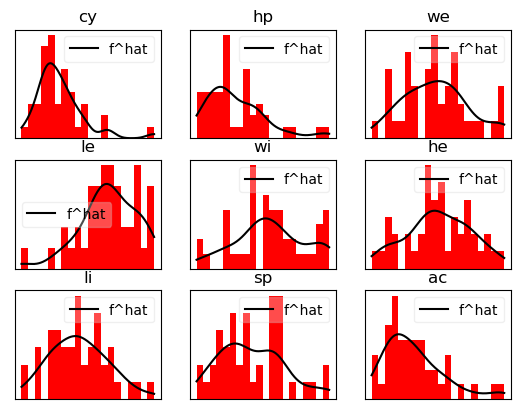

In [ ]:
# Get the observed x's for each explanatory variable
t0 = 0
x_cont0 = dat[dat['market'] == t0][nest_contvars].values.reshape((J[t0],len(nest_contvars)))
x_min0 = x_cont0[1:,:].min(axis = 0) # min of x's different from outside option
x_max0 = x_cont0[1:,:].max(axis = 0) # max -=-
n_points = 200
K0 = plot_kernel_estimate(x_cont0, nest_contvars, x_min0, x_max0, n_points, J[t0], outside_option = OO)

x_pairs = iter.product(np.arange(3), np.arange(3))
num_bins = 20

fig, axes = plt.subplots(3, 3)

for p,d in zip(x_pairs, np.arange(len(nest_contvars))):
    axes[p].hist(x_cont0[1:,d], num_bins, color = 'r', alpha = 1, density = True)
    axes[p].plot(np.linspace(x_min0[d], x_max0[d], n_points), K0[d,:], color = 'black', label = 'f^hat')
    axes[p].legend(framealpha = 0.3)
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)
    axes[p].set_title(nest_contvars[d])
    

plt.show()

## The space of characteristics

To get a sense of how we have chosen to model the similarity of products $j$ in the spaces of continuous characteristics $g$, we construct a scatterplot with the vectors $\psi^g_{(j)}$ against the characteristics $w_{(g)} = X_{t,k(g)}$ of products for market $t = 1$. To reduce overplotting we only plot the rows $\psi^g_{(j)}$ for a median product $j^g = \mathrm{med}(X_{t,k(g)})$ of each nesting structure $g$. Clearly, by construction, the distribution of characteristics will be Gaussian.

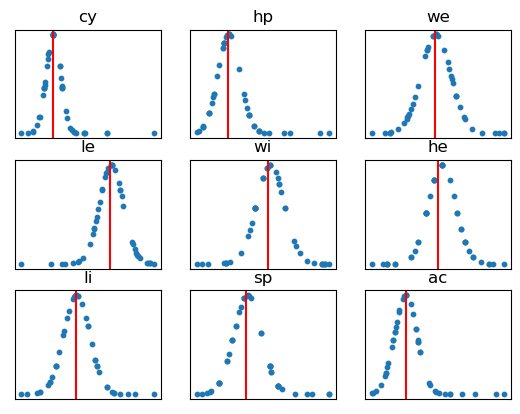

In [ ]:
x_medindex0 = np.empty((len(nest_contvars),), dtype = 'int64')

for d in np.arange(len(nest_contvars)):
    x_medindex0[d] = np.int64(np.argwhere(x_cont0[1:,d] == np.percentile(x_cont0[1:,d], 50, interpolation = 'higher'))[0])

x_pairs = iter.product(np.arange(3), np.arange(3))
num_bins = 20

fig, axes = plt.subplots(3, 3)

for p,d in zip(x_pairs, np.arange(len(nest_contvars))):
    if OO:
        axes[p].scatter(x_cont0[1:,d], Psi[0][(np.int64((d+2)*J[0]) + 1):(np.int64((d+3)*J[0])), x_medindex0[d] + 1], s = 10)
    else:
        axes[p].scatter(x_cont0[1:,d], Psi[0][np.int64((d+1)*J[0]):np.int64((d+2)*J[0]), x_medindex0[d]], s = 10)
    axes[p].axvline(np.median(x_cont0[1:,d]), color = 'r', label = 'median')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)
    axes[p].set_title(nest_contvars[d])

plt.show()

## Model solution

Suppose we are evaluating the choice probability function $P_t(u|\theta)$ at some parameter vector $\theta$. While it is possible to solve for the choice probabilities explicitly by numerical maximization, Fosgerau and Nielsen (2021) suggest a contraction mapping approach which is conceptually simpler. Let $u_t = X_t\beta$ for some parameter vector $\beta \in \mathbb{R}^{K}$, such that $\theta = (\beta', \lambda')'$, and let $q_t^0$ be an initial guess of the choice probabilities, e.g. $q_t^0\propto \exp(X_t\beta)$. Define further
$$
a=\sum_{g:\lambda_g\geq 0} \lambda_g   \qquad b=\sum_{g:\lambda_g<0} |\lambda_g|.
$$

The choice probabilities are then updated iteratively as
$$
q_t^{r} = \frac{e^{v_t^{r}}}{\sum_{j\in \mathcal J_t} e^{v_{tj}^{r}}},
$$
where
$$
v_t^{r} =\ln q_t^{r-1}+\left(u_t-\nabla_q \Omega_t(q^{r-1}_t|\lambda)\right)/(1+b).
$$
The gradient $\nabla_q \Omega_t(q_t|\lambda)$ is easily computed using the formula
$$
\nabla_q \Omega_t(q_t|\lambda) = \Gamma' \ln (\Psi q_t) - \delta + \iota_{J_t}
$$
For numerical stability, it can be a good idea to also do max-rescaling of $v^r_t$ at every iteration. The Kullback-Leibler divergence $D_{KL}(p||q)=p'\ln \frac{p}{q}$ decays linearly with each iteration,
$$
D_{KL}(p_t(\theta)||q_t^{r})\leq \frac{a+b}{1+b}D_{KL}(p_t(\theta)||q^{r-1}_t).
$$
This is implemented in the function "Similarity_ccp" below. 

In [ ]:
def Create_Gamma(Lambda, model):
    '''
    This function computes the Gamma matrix

    Args:
        Lambda: a (G,) numpy array of grouping parameters \lambda_g
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'

    Returns.
        Gamma: a dictionary of length T containing the ((G+1)*J[t],J[t]) numpy arrays of the \Gamma matrices for each market t.
    '''

    Psi = model['psi']
    T = len(Psi)
    J = np.array([Psi[t].shape[1] for t in np.arange(T)])
    
    Gamma = {}
    lambda0 = np.array([1 - sum(Lambda)])
    Lambda_full = np.concatenate((lambda0, Lambda)) # create vector (1- sum(lambda), lambda_1, ..., lambda_G)
    D = len(Lambda_full)
    
    for t in np.arange(T):
        Lambda_long =(Lambda_full[:,None]*np.ones((D,J[t]))).reshape((D*J[t],))
        Gamma[t] = Lambda_long[:,None]*Psi[t]

    return Gamma

In [ ]:
def Similarity_ccp(Theta, x, model, tol = 1.0e-15, maximum_iterations = 1000):
    '''
    This function finds approximations to the true conditional choice probabilities given parameters.

    Args.
        Theta: a numpy array (K+G,) of parameters
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'
        tol: tolerated approximation error
        maximum_iterations: a no. of maximum iterations which if reached will stop the algorithm

    Output
        q_1: a dictionary of T numpy arrays (J[t],) of Similarity choice probabilities for each market t
    '''

    # Objects in model specification
    psi = model['psi']
    phi = model['phi']

    T = len(x) # Number of markets
    K = x[0].shape[1] # Number of car characteristics

    # Parameters
    Beta = Theta[:K]
    Lambda = Theta[K:]
    G = len(Lambda)  # Number of groups

    # Calculate small b
    C_minus = np.array([True if Lambda[g] < 0 else False for g in np.arange(G)])
    if C_minus.all() == False:
        b = 0
    else:    
        b = np.abs(Lambda[C_minus]).sum() # sum of absolute value of negative lambda parameters.

    # Find the Gamma matrix
    Gamma = Create_Gamma(Lambda, model)

    u = {t: np.einsum('jk,k->j', x[t], Beta) for t in np.arange(T)} # Calculate linear utilities
    q = {t: np.exp(u[t] - u[t].max()) / np.exp(u[t] - u[t].max()).sum() for t in np.arange(T)}
    q0 = q
    Epsilon = 1.0e-10

    for k in range(maximum_iterations):
        q1 = {}
        for t in np.arange(T):
            # Calculate v
            psi_q = psi[t] @ q0[t] # Compute matrix product
            log_psiq =  np.log(np.abs(psi_q) + Epsilon) # Add Epsilon? to avoid zeros in log np.log(np.abs(gamma_q), out = np.NINF*np.ones_like(gamma_q), where = (np.abs(gamma_q) > 0))
            delta = phi[t]@Lambda
            Grad = (Gamma[t].T @ log_psiq) - delta # Compute matrix product
            v = np.log(q0[t] + Epsilon) + (u[t] - Grad)/(1 + b) # Calculate v = log(q) + (u - Gamma^T %o% log(Gamma %o% q) - delta)/(1 + b)
            v -= v.max(keepdims = True) # Do max rescaling wrt. alternatives

            # Calculate iterated ccp q^k
            numerator = np.exp(v)
            denom = numerator.sum()
            q1[t] = numerator/denom

        # Check convergence in an appropriate distance function
        dist = np.max(np.array([np.sum((q1[t]-q0[t])**2/q[t].std()) for t in np.arange(T)])) # Uses logit weights. This avoids precision issues when q1~q0~0.
        
        if dist<tol:
            break
        elif k==maximum_iterations:
            break
        else:
            None
            
        # Iteration step
        q0 = q1

    return q1

In [ ]:
beta0 = estimate_logit(q_logit, np.zeros((K,)), y, x, pop_share)['beta']
lambda0 = np.zeros((G,))
theta0 = np.append(beta0, lambda0)
q0 = Similarity_ccp(theta0, x, Model)

Optimization terminated successfully.
         Current function value: 0.001526
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29


## Demand derivatives and price Elasticity

While the demand derivatives in the Similarity Model are not quite as simple as in the Logit Model, they are still easy to compute. 
Let $q=P(u|\theta)$, then
$$
\nabla_u P(u|\theta)=\left(\nabla^2_{qq}\Omega(q|\lambda)\right)^{-1}-qq'
$$
where the $()^{-1}$ denotes the matrix inverse, and $\nabla^2_{qq}\Omega(q|\lambda) = \Gamma' \mathrm{diag}(\Psi q)^{-1} \Psi$ is the hessian of $\Omega$. The derivatives with respect to any $x_{tk\ell}$ can now easily be computed by the chain rule,
$$
    \frac{\partial P_j(u_t|\theta)}{\partial x_{tk\ell}}=\frac{\partial P_j(u_t|\theta)}{\partial u_{tk}}\frac{\partial u_{tk}}{\partial x_{tk\ell}}=\frac{\partial P_j(u_t|\theta)}{\partial u_{tk}}\beta_\ell,
$$

Finally, moving to price elasticity is the same as in the logit Model, if $x_{tk\ell}$ is the price of product $k$ in market $t$, then
$$
    \mathcal{E}_{jk}= \frac{\partial P_j(u_t|\theta)}{\partial x_{tk\ell}}\frac{1}{P_j(u_t|\theta)}=\frac{\partial P_j(u_t|\theta)}{\partial u_{tk}}\frac{1}{P_j(u_t|\theta)}\beta_\ell=\frac{\partial \ln P_j(u_t|\theta)}{\partial u_{tk}}\beta_\ell$$
we can also write this compactly as
$$
\nabla_u \ln P(u|\theta)=\mathrm{diag}(P(u|\theta))^{-1}\nabla_u P(u|\theta) = \mathrm{diag}(q)^{-1}\left[\left(\nabla^2_{qq}\Omega(q|\lambda)\right)^{-1}-qq'\right].
$$
Note that these elasticities may deviate significantly from the Logit elasticities. In particular, the IIA property will not generally apply to the Similarity Model. Additionally, the Similarity Model may detect both substitution and complementarity between products, contrasting it with well-known Nested Logit and Additive Random Utility Models according to which all products can only be substitutes. 

In [ ]:
def compute_pertubation_hessian(q, x, Theta, model):
    '''
    This function calucates the hessian of the pertubation function \Omega

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'
    
    Returns
        Hess: a dictionary of T numpy arrays (J[t],J[t]) of second partial derivatives of the pertubation function \Omega for each market t
    '''
    psi = model['psi']
    T = len(q.keys())
    K = x[0].shape[1]

    Gamma = Create_Gamma(Theta[K:], model) # Find the \Gamma matrices 
    
    Hess={}
    for t in np.arange(T):
        psi_q = np.einsum('cj,j->c', psi[t], q[t]) # Compute a matrix product
        Hess[t] = np.einsum('cj,c,cl->jl', Gamma[t], 1/psi_q, psi[t], optimize=True) # Computes the product \Gamma' diag(\psi q)^{-1} \psi (but faster)
        
    return Hess

In [38]:
def ccp_gradient(q, x, Theta, model):
    
    '''
    This function calucates the gradient of the choice proabilities wrt. characteristics

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'
    
    Returns
        Grad: a dictionary of T numpy arrays (J[t],K) of partial derivatives of the choice proabilities wrt. utilities for each market t
    '''

    T = len(q.keys())
    Grad = {}
    Hess = compute_pertubation_hessian(q, x, Theta, model) # Compute the hessian of the pertubation function

    for t in np.arange(T):
        inv_omega_hess = la.inv(Hess[t]) # (J,J) for each t=1,...,T , computes the inverse of the Hessian
        qqT = q[t][:,None]*q[t][None,:] # (J,J) outerproduct of ccp's for each market t
        Grad[t] = inv_omega_hess - qqT  # Compute Similarity gradient of ccp's wrt. utilities

    return Grad

In [39]:
def Similarity_u_grad_Log_ccp(q, x, Theta, model):
    '''
    This function calucates the gradient of the log choice proabilities wrt. characteristics

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'
    
    Returns
        Epsilon: a dictionary of T numpy arrays (J[t],J[t]) of partial derivatives of the log choice proabilities of products j wrt. utilites of products k for each market t
    '''

    T = len(q.keys())
    Epsilon = {}
    Grad = ccp_gradient(q, x, Theta, model) # Find the gradient of ccp's wrt. utilities
    
    for t in np.arange(T):
        Epsilon[t] = Grad[t]/q[t][:,None] # Computes diag(q)^{-1}Grad[t]

    return Epsilon

In [40]:
def Similarity_elasticity(q, x, Theta, model, char_number = K-1):
    ''' 
    This function calculates the elasticity of choice probabilities wrt. any characteristic or nest grouping of products

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'
        char_number: an integer which is an index of the parameter in theta wrt. which we wish calculate the elasticity. Default is the index for the parameter of 'pr'.

    Returns
        a dictionary of T numpy arrays (J[t],J[t]) of choice probability semi-elasticities for each market t
    '''
    T = len(q.keys())
    Epsilon = {}
    Grad = Similarity_u_grad_Log_ccp(q, x, Theta, model) # Find the gradient of log ccp's wrt. utilities

    for t in np.arange(T):
        Epsilon[t] = Grad[t]*Theta[char_number] # Calculate semi-elasticities

    return Epsilon

## Maximum likelihood estimation of Similarity

The log-likelihood contribution of market t is
$$
\ell_t(\theta)=y_t'\ln P_t(u_t|\theta),
$$
and an estimation routine must therefore have a function that - given $\mathbf{X}_t$ and $\theta$ - calculates $u_t=\mathbf{X}_t\beta$ and then calls the fixed point routine described above. That routine will return the choice probabilities $P_t(u_t|\theta)$, and we can then evaluate $\ell_t(\theta)$. Using our above defined functions we now construct precisely such an estimation procedure.

In addition, when maximizing the likelihood we want the derivates at some $\theta=(\beta',\lambda')$. Let $q_t= P_t(u_t|\theta)$, then we have
$$
\nabla_\theta \ln P_t(u_t|\theta)=\mathrm{diag}(q_t)^{-1}\left(\nabla_{qq}^2\Omega_t(q_t|\lambda)^{-1}-q_tq_t' \right)\left[\mathbf{X}_t,-\nabla_{q,\lambda}^2 \Omega_t(q_t|\lambda)\right]
$$
Note that the first two components is the elasticity $\nabla_u \ln P_t(u_t|\theta)$ and the last term is a block matrix of size $J\times (K+G)$. The latter cross derivative $\nabla_{q,\lambda}^2 \Omega_t(q_t|\lambda)$ may be computed using the identity $\nabla_{q,\lambda}^2 \Omega_t(q_t|\lambda)_g = -\ln(q) + (\Psi^g)' \ln(\Psi^g q) - \varphi^g$ for each row $g=1,\ldots,G$. The derivative of the log-likelihood function can then be obtained from this as
$$
\nabla_\theta \ell_t(\theta)= y_t' \left(\nabla_\theta \ln P_t(u_t|\theta)\right) \\
$$

In [41]:
def Similarity_loglikelihood(Theta, y, x, sample_share, model):
    ''' 
    This function computes the loglikehood contribution for each individual i.
    
    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        sample_share: a numpy array (T,) of the share of observations of each market t = 1,...,T
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'

    Output
        ll: a numpy array (T,) of Similarity loglikelihood contributions
    '''

    T = len(x.keys())
    K = x[0].shape[1]
    ccp_hat = Similarity_ccp(Theta, x, model) # Find Similarity choice probabilities
    sum_lambdaplus = np.array([theta for theta in Theta[K:] if theta >0]).sum() # Get sum of positive Lambda's
    
    ll=np.empty((T,))
    for t in np.arange(T):
        ll[t] = sample_share[t]*(y[t].T@np.log(ccp_hat[t])) # np.einsum('j,j', y[t], np.log(ccp_hat[t], out = -np.inf*np.ones_like(ccp_hat[t]), where = (ccp_hat[t] > 0)))

    print([sum_lambdaplus, -ll.mean()])

    return ll

In [42]:
def q_Similarity(Theta, y, x, sample_share, model):
    ''' The negative loglikelihood criterion to minimize
    '''
    Q = -Similarity_loglikelihood(Theta, y, x, sample_share, model)
    
    return Q

We also implement the derivative of the loglikehood wrt. parameters $\nabla_\theta \ell_t(\theta)$.

In [43]:
def cross_grad_pertubation(q, model):
    ''' 
    This function calculates the cross diffential of the pertubation function \Omega wrt. first ccp's and then the lambda parameters

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'
    
    Returns
        Z: a dictionary of T numpy arrays (J[t],G) of cross diffentials of the pertubation function \Omega wrt. first ccp's and then the lambda parameters
    '''

    # Get psidim object from the model specification
    psidim = model['psi_3d']
    phi = model['phi']

    # Get the amount of markets
    T = len(q.keys())

    # Initialize Z; the cross differential of the pertubation function
    Z = {}
    
    for t in np.arange(T):
        log_q = log_q = np.log(q[t], out = -np.inf*np.ones_like(q[t]), where = (q[t] > 0))
        psidim_t = psidim[t][1:,:,:] # Get each of the Psi^g nesting matrices
        psiq = psidim_t @ q[t] # Computes a matrix product
        log_psiq = np.log(psiq, out = np.NINF*np.ones_like(psiq), where = (psiq > 0))
        Z[t] = - log_q[:,None] + np.einsum('dkj,dk->jd', psidim_t, log_psiq) - phi[t] # Compute cross differential
    
    return Z

In [44]:
def cross_grad_pertubation_old(q, psi, phi):
    ''' 
    This function calculates the cross diffential of the pertubation function \Omega wrt. first ccp's and then the lambda parameters

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        psi: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    
    Returns
        Z: a dictionary of T numpy arrays (J[t],G) of cross diffentials of the pertubation function \Omega wrt. first ccp's and then the lambda parameters
    '''

    T = len(q.keys())
    J = np.array([q[t].shape[0] for t in np.arange(T)])
    G = np.int32((psi[0].shape[0] / J[0]) - 1)
    
    Z = {}

    for t in np.arange(T):
        log_q = np.log(q[t], out = -np.inf*np.ones_like(q[t]), where = (q[t] > 0))
        Psi_t = psi[t]
        Z_t = np.empty((J[t], G))

        for g in np.arange(1,G+1):
            Psi_d = Psi_t[g*J[t]:(g+1)*J[t],:]
            Psiq = np.einsum('cj,j->c', Psi_d, q[t])
            log_psiq = np.log(Psiq, out = -np.inf*np.ones_like(Psiq), where = (Psiq > 0))
            Z_t[:,g-1] = -log_q + np.einsum('cj,c->j', Psi_d, log_psiq) - phi[t][:,g-1]

        Z[t] = Z_t
    
    return Z

In [45]:
def Similarity_theta_grad_log_ccp(Theta, x, model):
    '''
    This function calculates the derivative of the Similarity log ccp's wrt. parameters theta

    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'
    Returns
        Grad: a dictionary of T numpy arrays (J[t],K+G) of derivatives of the Similarity log ccp's wrt. parameters theta for each market t
    '''

    T = len(x.keys())

    q = Similarity_ccp(Theta, x, model) # Find choice probabilities

    Z = cross_grad_pertubation(q, model) # Find cross differentials of the pertubation function
    u_grad = Similarity_u_grad_Log_ccp(q, x, Theta, model)  # Find the gradient of log ccp's wrt. utilities
    Grad={}

    for t in range(T):
        G = np.concatenate((x[t], -Z[t]), axis = 1) # Compute the block matrix
        Grad[t] = u_grad[t] @ G # Compute the derivative wrt. parameters

    return Grad

In [46]:
def Similarity_score(Theta, y, x, sample_share, model):
    '''
    This function calculates the score of the Similarity loglikelihood.

    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        sample_share: a numpy array (T,) of the share of observations of each market t = 1,...,T
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'

    Returns
        Score: a numpy array (T,K+G) of Similarity scores
    '''
    T = len(x.keys())

    log_ccp_grad = Similarity_theta_grad_log_ccp(Theta, x, model) # Find derivatives of Similarity log ccp's wrt. parameters theta
    D = len(Theta) # equal to K+G
    Score = np.empty((T,D))
    
    for t in np.arange(T):
        Score[t,:] =sample_share[t]*(log_ccp_grad[t].T@y[t]) #np.einsum('j,jd->d', y[t], log_ccp_grad[t]) # Computes a matrix product

    return Score

In [47]:
def Similarity_score_unweighted(Theta, y, x, model):
    '''
    This function calculates the score of the Similarity loglikelihood.

    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'

    Returns
        Score: a numpy array (T,K+G) of Similarity scores
    '''
    T = len(x.keys())

    log_ccp_grad = Similarity_theta_grad_log_ccp(Theta, x, model) # Find derivatives of Similarity log ccp's wrt. parameters theta
    D = log_ccp_grad[0].shape[1] # equal to K+G
    Score = np.empty((T,D))
    
    for t in np.arange(T):
        Score[t,:] = log_ccp_grad[t].T@y[t] #np.einsum('j,jd->d', y[t], log_ccp_grad[t]) # Computes a matrix product

    return Score

In [48]:
def q_Similarity_score(Theta, y, x, sample_share, model):
    ''' The derivative of the negative loglikelihood criterion
    '''
    return -Similarity_score(Theta, y, x, sample_share, model)

### Testing the score function

To make sure that our optimization procedure works as intended and is precise, we may calculate the normed difference of the numerical and our analytical gradients of the likelihood function $\ell_t(\theta)$ at some parameter $\hat \theta^0$.

In [49]:
def test_analyticgrad(y, x, theta, sample_share, model, delta = 1.0e-8):
    ''' 
    This function calculates the numerical and the analytical score functions at a given parameter \theta aswell the norm of their difference

    Args:
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        sample_share: a numpy array (T,) of the share of observations of each market t = 1,...,T
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'
        delta: the incremental change in the argument, a float, used in calculating numerical gradients

    Returns.
        normdiff: a float of the euclidean norm of the difference between the numerical and analytical score functions at \theta
        angrad: a numpy array (T,K+G) of analytical Similarity scores
        numgrad: a numpy array (T,K+G) of numerical Similarity scores
    '''

    T = len(x)
    K = x[0].shape[1]
    G = len(theta[K:])

    numgrad = np.empty((T, K+G))

    for i in np.arange(K+G):
        vec = np.zeros((K+G,))
        vec[i] = 1
        numgrad[:,i] = (Similarity_loglikelihood(theta + delta*vec, y, x, sample_share, model) - Similarity_loglikelihood(theta, y, x, sample_share, model)) / delta

    angrad = Similarity_score(theta, y, x, sample_share, model)

    normdiff = la.norm(angrad - numgrad)
    
    return normdiff, angrad, normdiff

diff, an, num = test_analyticgrad(y, x, theta0, pop_share, Model)
diff

## Standard errors in Maximum Likelihood estimation

As usual we may consistently estimate the covariance matrix of the Similarity maximum likelihood estimator $\hat \theta^{\text{MLE}}$ by the inverse information matrix:

$$
\hat \Sigma = \left( \sum_{t=1}^T s_t\nabla_\theta \ell_t \left(\hat \theta^{\text{MLE}}\right) \nabla_\theta \ell_t \left(\hat \theta^{\text{MLE}}\right)' \right)^{-1}
$$

Accordingly we may find the estimated standard error of parameter $d = 1,\ldots,K+G$ as the squareroot of the $d$'th diagonal entry of $\hat \Sigma$:

$$
\hat \sigma_d = \sqrt{\hat \Sigma_{dd}}
$$

In [50]:
def Similarity_se(score, sample_share, N):
    '''
    This function computes the asymptotic standard errors of the MLE.

    Args.
        score: a numpy array (T,K+G) of Similarity scores as outputted by the function 'Similarity_score_unweighted'.
        sample_share: a numpy array (T,) of the share of observations of each market t = 1,...,T
        N: an integer giving the number of observations

    Returns
        SE: a numpy array (K+G,) of asymptotic Similarity MLE standard errors
    '''

    SE = np.sqrt(np.diag(la.inv(np.einsum('td,tm->dm', sample_share[:,None]*score, score))) / N) # Compute standard errors by taking the squareroot of the diagonal elements of the variance estimate

    return SE

In [51]:
def Similarity_t_p(SE, Theta, N, Theta_hypothesis = 0):
    ''' 
    This function calculates t statistics and p values for characteristic and nest grouping parameters

    Args.
        SE: a numpy array (K+G,) of asymptotic Similarity MLE standard errors
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        N: an integer giving the number of observations
        Theta_hypothesis: a (K+G,) array or integer of parameter values to test in t-test. Default value is 0.
    
    Returns
        T: a (K+G,) array of estimated t tests
        p: a (K+G,) array of estimated asymptotic p values computed using the above t-tests
    '''

    T = np.abs(Theta - Theta_hypothesis) / SE # Compute two-sided t-tests
    p = 2*scstat.t.sf(T, df = N-1) # Compute p-values

    return T,p

### We now estimate the model

In [52]:
def estimate_Similarity(f, Theta0, y, x, sample_share, model, N, Analytic_jac:bool = True, options = {'disp': True}, **kwargs):
    ''' 
    Takes a function and returns the minimum, given starting values and variables necessary in the Similarity Model specification.

    Args:
        f: a function to minimize,
        Theta0 : a numpy array (K+G,) of initial guess parameters (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        sample_share: a numpy array (T,) of the share of observations of each market t = 1,...,T,
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification',
        N: an integer giving the number of observations,
        Analytic_jac: a boolean. Default value is 'True'. If 'True' the analytic jacobian of the Similarity loglikelihood function is used in estimation. Else the numerical jacobian is used.
        options: dictionary with options for the optimizer (e.g. disp=True which tells it to display information at termination.)
    
    Returns:
        res: a dictionary with results from the estimation.
    '''

    # The objective function is the average of q(), 
    # but Q is only a function of one variable, theta, 
    # which is what minimize() will expect
    Q = lambda Theta: np.mean(f(Theta, y, x, sample_share, model))

    if Analytic_jac == True:
        Grad = lambda Theta: np.mean(q_Similarity_score(Theta, y, x, sample_share, model), axis=0) # Finds the Jacobian of Q. Takes mean of criterion q derivatives along axis=0, i.e. the mean across individuals.
    else:
        Grad = None

    # call optimizer
    result = optimize.minimize(Q, Theta0.tolist(), options=options, jac=Grad, **kwargs) # optimize.minimize takes a list of parameters Theta0 (not a numpy array) as initial guess.
    
    # Find estimated standard errors, t-tests, and p-values
    se = Similarity_se(Similarity_score_unweighted(result.x, y, x, model), sample_share, N) # Calculate standard errors using the unweighted score contributions from each market
    T,p = Similarity_t_p(se, result.x, N)

    # collect output in a dict 
    res = {
        'theta': result.x,
        'se': se,
        't': T,
        'p': p,
        'success':  result.success, # bool, whether convergence was succesful 1
        'nit':      result.nit, # no. algorithm iterations 
        'nfev':     result.nfev, # no. function evaluations 
        'fun':      result.fun # function value at termination 
    }

    return res

In [53]:
beta_0 = np.ones((K,))

# Estimate the model
Logit_beta = estimate_logit(q_logit, beta_0, y, x, sample_share=pop_share, Analytic_jac=True)['beta']
Logit_SE = logit_se(logit_score_unweighted(Logit_beta, y, x), pop_share, N)
Logit_t, Logit_p = logit_t_p(Logit_beta, logit_score_unweighted(Logit_beta, y, x), pop_share, N)

# Initialize \theta^0
theta0 = np.append(Logit_beta,lambda0)

Optimization terminated successfully.
         Current function value: 0.001529
         Iterations: 26
         Function evaluations: 34
         Gradient evaluations: 34


In [54]:
resMLE = estimate_Similarity(q_Similarity, theta0, y, x, pop_share, Model, N)

[0.0, 0.001528535134161618]
[3.7176505867959405e-06, 0.001528530844629761]
[1.8588252933979702e-05, 0.001528514281678381]
[7.807066232271476e-05, 0.0015284575876433064]
[0.0002888968393993265, 0.0015283779712649036]
[0.0003156820978933802, 0.0015283756589398688]
[0.0004228231318695951, 0.001528366650756558]
[0.0008514977339305401, 0.0015283344814752554]


[0.002552430433766674, 0.0015282508819820435]
[0.011407411931886541, 0.001528002344870776]
[0.0336266372510129, 0.001527432169794866]
[0.07652390229927372, 0.0015264248802469536]
[0.1598061804339339, 0.0015247252520192492]
[0.3261793453534204, 0.0015224054228309036]
[0.41714512626147443, 0.0015215190856618535]
[0.43667551144630096, 0.0015212756051922887]
[0.4294172691651903, 0.0015212519744114967]
Optimization terminated successfully.
         Current function value: 0.001521
         Iterations: 11
         Function evaluations: 17
         Gradient evaluations: 17


In [55]:
def reg_table(theta, se, N, x_vars, nest_vars):
    '''
    This function constructs a regression table based on Similarity parameter standard error estimates

    Args:
        theta: a (K+G,) numpy array of estimated parameters
        se: a (K+G,) numpy array of estimated standard errors
        N: an integer; the number of observations
        x_vars: a list containing the names of the covariates
        nest_vars: a list containing the names of the nesting groups

    Returns.
        table: a pandas dataframe structured as a regression table w. parameter estiamtes, standard errors, t-tests, and p-values  
    '''
    Similarity_t, Similarity_p = Similarity_t_p(se, theta, N) # Get t-test values and p values

    if OO:
        regdex = [*x_vars, *['group_' + var for var in nest_vars]] # Set the names of the covariates and the nesting groups as the index
    else:
        regdex = [*x_vars, *['group_' + var for var in nest_vars]] # -=-

    table  = pd.DataFrame({'theta': [ str(np.round(theta[i], decimals = 4)) + '***' if Similarity_p[i] <0.01 else str(np.round(theta[i], decimals = 3)) + '**' if Similarity_p[i] <0.05 else str(np.round(theta[i], decimals = 3)) + '*' if Similarity_p[i] <0.1 else np.round(theta[i], decimals = 3) for i in range(len(theta))], # Give stars to parameter estimates according to t-tests at levels of significance 0.1, 0.05, and 0.01
                'se' : np.round(se, decimals = 5),
                't (theta == 0)': np.round(Similarity_t, decimals = 3),
                'p': np.round(Similarity_p, decimals = 3)}, index = regdex).rename_axis(columns = 'variables')
    
    return table

In [56]:
Similarity_theta = resMLE['theta']
Similarity_SE = resMLE['se']
Similarity_t, Similarity_p = Similarity_t_p(Similarity_SE, Similarity_theta, N)
reg_table(Similarity_theta, Similarity_SE, N, x_vars, nest_vars)

variables,theta,se,t (theta == 0),p
in_out,-2.5498***,0.43873,5.812,0.000
cy,-0.318,0.22618,1.408,0.159
hp,-0.457*,0.27293,1.676,0.094
we,-0.9464***,0.22234,4.256,0.000
le,-1.9569***,0.30143,6.492,0.000
wi,-2.0975***,0.42346,4.953,0.000
he,-2.0849***,0.31568,6.604,0.000
li,-0.7439***,0.11864,6.270,0.000
sp,-1.3924***,0.27032,5.151,0.000
ac,-0.055,0.10572,0.522,0.601


In [57]:
np.array([p for p in Similarity_theta[K:] if p>0]).sum()

0.4294172691651903

### An alternative approach

The log-likelihood function is not globally concave, and finding the global optimum can be difficult. Using the estimation procedure of Fosgerau et. al. (2023 working paper), we can instead fit the parameters using the first-order conditions  for optimality $0=u(X_t,\beta) - \nabla_q \Omega_t(\hat q_t^0|\lambda)$ and the observed market shares $\hat q^0_t$ or some non-parametric estimate of the CCP's. The estimator takes the form

$$
\hat \theta^0=\arg \min_{\theta} \sum_t s_t \hat \varepsilon^0_t(\theta)'\hat W^0_t\hat \varepsilon^0 _t(\theta),
$$
where $\hat W^0_t$ is a positive semidefinite weight matrix, $s_t$ is market $t$'s share of the total population
$$
\hat \varepsilon^0_t(\theta) = \hat D^0_t(u(X_t,\beta)- \nabla_q \Omega_t(\hat q_t^0|\lambda)) ,
$$
is the residual of the first-order conditions utilizing the logit derivatives of CCP's wrt. utilities
$$
\hat D^0_t=\textrm{diag}(\hat q^0_t)-\hat q^0_t (\hat q^0_t)'.
$$
Using equation (...) above, we have that $\hat \epsilon_t$ is a linear function of $\theta$,
$$
\hat \varepsilon^0_t(\theta)=\hat D^0_t \left(\hat G^0_t\theta- \ln \hat q^0_t\right)\equiv \hat A^0_t\theta-\hat r^0_t.
$$
With $\hat G^0_t = [X_t, -\nabla^2_{q,\lambda} \Omega (q^0_t|\lambda)]$, $\hat A^0_t = \hat D^0_t \hat G^0_t$ and $\hat r^0_t = \hat D^0_t \ln \hat q^0_t $. Using linearity, the weighted least squares criterion has a unique closed form solution,
$$
\hat \theta^0 =\left(\sum_t s_t (\hat A^0_t)'\hat W^0_t \hat A^0_t \right)^{-1}\left(\sum_t s_t (\hat A^0_t)'\hat W^0_t \hat r_t^0 \right)
$$

In our estimation procedure we will use the inverse of the matrix with the observed market shares CCP's $\hat q^0_t$ along its main diagonal $\hat W^0_t = \mathrm{diag}(\hat q^0_t)^{-1}$.

In [58]:
def G_array(q, x, model):
    ''' 
    This function calculates the G block matrix

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'

    Returns
        G: a dictionary  of T numpy arrays (J[t],K+G): a G matrix for each market t
    '''
    T = len(x)

    Z = cross_grad_pertubation(q, model) # Find the cross derivative of the pertubation function \Omega wrt. lambda and ccp's q
    G = {t: np.concatenate((x[t],-Z[t]), axis=1) for t in np.arange(T)} # Join block matrices along 2nd dimensions  s.t. last dimension is K+G (same dimension as theta)

    return G

In [59]:
def D_array(q):
    '''
    This function calculates the D matrix - the logit derivative of ccp's wrt. utilities

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t

    Returns
        D: a dictionary of T numpy arrays (J[t],J[t]) of logit derivatives of ccp's wrt. utilities for each market t
    '''
    T = len(q)

    D = {t: np.diag(q[t]) - np.einsum('j,k->jk', q[t], q[t]) for t in np.arange(T)} # Compute logit derivatives of ccp's wrt. utilities
    
    return D

In [60]:
def A_array(q, x, model):
    '''
    This function calculates the A matrix

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'

    Returns
        A: a dictionary  of T numpy arrays (J[t],K+G): an A matrix for each market t
    '''
    T = len(x)

    D = D_array(q) # Compute the derivatives of logit ccp's
    G = G_array(q, x, model) # Get the G block matrix
    A = {t: np.einsum('jk,kd->jd', D[t], G[t]) for t in np.arange(T)} # Compute a matrix product for each market t

    return A

In [61]:
def r_array(q):
    '''
    This function calculates 'r'; the logarithm of observed or nonparametrically estimated market shares

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
    
    Returns
        r: a dictionary of T numpy arrays (J[t],) of the log of ccp's for each market t
    '''
    T = len(q)

    D = D_array(q) 
    log_q = {t: np.log(q[t], out = -np.inf*np.ones_like(q[t]), where = (q[t] > 0)) for t in np.arange(T)} # Take logs of ccp-s
    r = {t: np.einsum('jk,k->j', D[t], log_q[t]) for t in np.arange(T)} # Compute matrix product

    return r

In [62]:
def WLS_init(q, x, sample_share, model, N):
    ''' 
    This function calculates the weighted least squares estimator \hat \theta^k and its relevant estimated standard error for the initial FKN parameter estimates.

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        sample_share: A (T,) numpy array of the fraction of observations in each market t 
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'
        N: An integer giving the total amount of observations

    Returns
        theta_hat: a (K+G,) numpy array of initial FKN parameter estimates
        se_hat: a (K+G,) numpy array of standard errors for initial FKN parameter estimates
    '''

    T = len(x)

    A = A_array(q, x, model)
    r = r_array(q)

    d = A[0].shape[1] # Get the total number of parameters; this is equal to K+G
    
    # Initialize AWA and AWr matrices
    AWA = np.empty((T,d,d))
    AWr = np.empty((T,d))

    for t in np.arange(T):
        AWA[t,:,:] = sample_share[t]*np.einsum('jd,j,jp->dp', A[t], 1/q[t], A[t], optimize = True) # Fast product using that the weights 'W' are diagonal.
        AWr[t,:] = sample_share[t]*np.einsum('jd,j,j->d', A[t], 1/q[t], r[t], optimize = True)
    
    theta_hat = la.solve(AWA.sum(axis = 0), AWr.sum(axis = 0)) # Solve system of equations AWA.sum()*theta = AWr.sum() for parameter estimates theta
    #se_hat = np.sqrt(np.diag(la.inv(AWA.sum(axis = 0))) / N)
    
    return theta_hat
    

Using the observed market shares we may thus find initial parameter estimates $\hat \theta^0$ as described above.

In [63]:
thetaFKN0 = WLS_init(y, x, pop_share, Model, N)

In [64]:
np.array([p for p in thetaFKN0[K:] if p > 0]).sum()

1.218988344960131

## Regularization for parameter bounds

As we see above, the least squares estimator is not guaranteed to respect the parameter bounds $\sum_g \hat \lambda_g<1$. We can use that if we replace $\hat q^0_t$ with the choice probabilities from the maximum likelihood estimator of the Logit Model, $\hat q^{logit}_t\propto \exp\{X_t\hat \beta^{logit}\}$, and plug these choice probabilities into the WLS estimator described above, it will return $\hat \theta=(\hat \beta^{logit},0,\ldots,0)$ as the parameter estimate. Let $\hat q_t(\alpha)$ denote the weighted average of the logit probabilites and the market shares,
$$
\hat q_t(\alpha) =(1-\alpha) \hat q^{logit}_t+\alpha \hat q^0_t.
$$
 Let $\hat \theta^0(\alpha)$ denote the resulting parameter vector. We perform a line search for values of $\alpha$, $(\frac{1}{2},\frac{1}{4},\frac{1}{8},\ldots)$ until $\hat \theta^0(\alpha)$ yields a feasible parameter vector.


In [65]:
def LogL(Theta, y, x, sample_share, model):
    ''' 
    A function giving the mean Similarity loglikehood evaluated at data and an array of parameters 'Theta'
    '''
    return np.mean(Similarity_loglikelihood(Theta, y, x, sample_share, model))

In [66]:
def LineSearch(Logit_Beta, q_obs, x, sample_share, model, N):
    '''
    This function performs a line search to find feasible lambda parameters

    Args:
        Logit_beta: a (K,) numpy array of estimated beta parameters from a corresponding Logit Model
        q_obs: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        sample_share: a numpy array (T,) of the share of observations of each market t = 1,...,T,
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification',
        N: an integer giving the number of observations

    Returns.
        theta_alpha: a (K+G,) numpy array of feasible parameters found by line search
    '''

    # Get dimensions of data
    T = len(x)
    K = x[0].shape[1]

    # Find probabilities
    q_logit = logit_ccp(Logit_Beta, x)

    # Search over alphas s.t. alpha = (1/2)^{k} for some positive integer k
    alpha0 = 0.5

    for k in np.arange(1,100):

        # Set alpha
        alpha = alpha0**k 
        
        # Compute convex combination of ccp's
        q_alpha = {t: (1 - alpha)*q_logit[t] + alpha*q_obs[t] for t in np.arange(T)}
        theta_alpha = WLS_init(q_alpha, x, sample_share, model, N) # Compute initial FKN parameters but using q_alpha ccp's 

        lambda_alpha = theta_alpha[K:] # Find lambda parameters
        pos_pars = np.array([theta for theta in lambda_alpha if theta > 0]) # Find positive lambda parameters

        if pos_pars.sum() <1:
            break # Break if positive parameters sum to less than 1

    return theta_alpha

In [67]:
def GridSearch(Logit_Beta, y, x, sample_share, model, N, num_alpha = 5):
    '''
    This function performs a grid search on the unit interval to find feasible parameters \theta

    Args:
        Logit_beta: a (K,) numpy array of estimated beta parameters from a corresponding Logit Model
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        sample_share: a numpy array (T,) of the share of observations of each market t = 1,...,T,
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification',
        N: an integer giving the number of observations,
        num_alpha: an integer of the number of alphas for which the search is to be performed

    Returns.
        theta_star: a (K+G,) numpy array of feasible parameters found by grid search
    '''

    T = len(x)
    J0 = x[0].shape[0]
    psi_3d0 = model['psi_3d'][0]
    G = np.int64(psi_3d0.shape[0] - 1)
    K = x[0].shape[1]

    # Find probabilities
    q_logit = logit_ccp(Logit_Beta, x)
    q_obs = y

    # Search
    alpha_line = np.linspace(0, 1, num_alpha)
    LogL_alpha = np.empty((num_alpha,))
    theta_alpha = np.empty((num_alpha,K+G))

    for k in np.arange(len(alpha_line)):

        alpha = alpha_line[k]

        q_alpha = {t: (1 - alpha)*q_logit[t] + alpha*q_obs[t] for t in np.arange(T)}
        theta_alpha[k,:] = WLS_init(q_alpha, x, sample_share, model, N)

        #lambda_inout = theta_alpha[k,K]
        lambda_alpha = theta_alpha[k,K:] # theta_alpha[k,K+1:]
        pos_pars = np.array([theta for theta in lambda_alpha if theta > 0])

        if (pos_pars.sum() >= 1): #|(lambda_inout >= 1)
            LogL_alpha[k] = np.NINF
        else:
            LogL_alpha[k] = LogL(theta_alpha[k,:], y, x, sample_share, model)
    
    # Pick the best set of parameters
    alpha_star = np.argmax(LogL_alpha)
    theta_star = theta_alpha[alpha_star,:]

    return theta_star

Implementing the line search method we find corressponding parameters $\hat \theta^*$.

In [68]:
theta_alpha = LineSearch(Logit_beta, y, x, pop_share, Model, N)

In [69]:
q_Similarity(theta_alpha, y, x, pop_share, Model).mean()

[0.7549534173977517, 0.0015132588931061905]


0.0015132588931061905

## Iterated FKN estimator

The initial estimator $\hat \theta^0$ is usually biased. However this can be accommodated for via iterating a similar estimator on the estimator $\hat \theta^0$. The iterated estimator is as the initial one, except there is an additional term on $\hat \varepsilon$. First, we update the choice probabilities,
$$
\hat q^k_t=p(\mathbf X_t,\hat \theta^{k-1})\\
$$
Then we assign
$$
\hat D^k_t=\nabla^2_{qq}\Omega(\hat q_t^k|\hat \lambda^{k-1})^{-1}-(\hat q^k_t \hat q^k_t)'
$$
and then construct the residual
$$
\hat \varepsilon^k_t(\theta)=\hat D^k_t\left( u(x_t,\beta)-\nabla_q \Omega(\hat q_t^k|\lambda)\right) -y_t+\hat q_t^k,
$$
Which can once again be simplified as
$$
\hat \varepsilon^k_t(\theta)= \hat A_t^k \theta-\hat r^k_t,
$$
where
$$
\hat A^k_t=\hat D_t^k\hat G^k_t, \hat r_t^k =\hat D^k_t\ln \hat q_t^k-y_t
$$
and where $\hat G^k_t$ is constructed as in the initial estimator. Using the weighted least squares estimator with weights $\hat W_t^k=\textrm{diag}(\hat q^k_t)^{-1}$, we get the estimator
$$
\hat \theta^k = \arg \min_{\theta}\frac{1}{T}\sum_t \hat \varepsilon^k_t(\theta)'\hat W_t^k \hat \varepsilon^k_t(\theta).
$$
We can once again solve it in closed form as
$$
\hat \theta^k =\left( \frac{1}{T}\sum_t  ( \hat A^k_t)'\hat W_t^k \hat A^k_t\right)^{-1}\left( \frac{1}{T}\sum_t (\hat A_t^k)'\hat W_t^k \hat r_t^k\right)
$$

FKN (2021) show that the estimator $\hat \theta^k$ converges to the (true) MLE $\hat \theta^{\text{MLE}}$ as the number of iterations approaches infinity, avoiding thereby 

Now we implement this procedure and iterate starting from our initial guess $\hat \theta^{*}$


In [70]:
def WLS(Theta, y, x, sample_share, model, N):
    '''
    This function calculates the weighted least squares estimator \hat \theta^k and its relevant estimated standard error for the iterated parameter estimates.

    Args:
        Theta: a (K+G,) numpy array of previously estimated \theta parameters
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        sample_share: a numpy array (T,) of the share of observations of each market t = 1,...,T,
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification',
        N: an integer giving the number of observations,

    Returns.
        theta_hat: a (K+G,) numpy array of iterated FKN parameter estimates
        se_hat: a (K+G,) numpy array of standard errors for iterated FKN parameter estimates
    '''
    T = len(x)
    d = Theta.shape[0]
    
    # Get ccp's
    q = Similarity_ccp(Theta, x, model)

    # Construct A
    D = ccp_gradient(q, x, Theta, model) # A is here constructed using the Similarity derivative of ccp's wrt. utilities instead of the Logit derivative
    G = G_array(q, x, model)
    A = {t: np.einsum('jk,kd->jd', D[t], G[t]) for t in np.arange(T)}

    # Construct r
    log_q = {t: np.log(q[t], out = -np.inf*np.ones_like(q[t]), where=(q[t] > 0)) for t in np.arange(T)}
    r = {t: np.einsum('jk,k->j', D[t], log_q[t]) + y[t] for t in np.arange(T)} # r = D %o% log(q) + y

    # Estimate parameters
    AWA = np.empty((T,d,d))
    AWr = np.empty((T,d))

    for t in np.arange(T):
        AWA[t,:,:] = sample_share[t]*np.einsum('jd,j,jp->dp', A[t], 1./q[t], A[t], optimize = True)
        AWr[t,:] = sample_share[t]*np.einsum('jd,j,j->d', A[t], 1./q[t], r[t], optimize = True)

    theta_hat = la.solve(AWA.sum(axis = 0), AWr.sum(axis = 0))
    se_hat = np.sqrt(np.diag(la.inv(AWA.sum(axis = 0))) / N)

    return theta_hat,se_hat

In [71]:
def FKN_estimator(logit_beta, q_obs, x, sample_share, model, N, tol = 1.0e-15, max_iters = 1000):
    '''
    This function estimates the Similarity Model via the FKN estimator

    Args:
        logit_beta: a (K,) numpy array of estimated beta parameters from a corresponding Logit Model
        q_obs: a dictionary of T numpy arrays (J[t],) of observed choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        sample_share: A (T,) numpy array of the fraction of observations in each market t 
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'
        N: An integer giving the total amount of observations

    Returns.
        res: a dictionary containing FKN parameter estimates, standard errors, iterations to convergence, etc.
    '''

    K = x[0].shape[1]

    # Get initial FKN parameters using observed market shares
    theta_init = WLS_init(q_obs, x, sample_share, model, N) 
    
    # If the positive nesting paramters sum to more than 1, then perform a linesearch.
    if (np.array([p for p in theta_init[K:] if p>0]).sum() >= 1):
        theta_star = LineSearch(logit_beta, q_obs, x, sample_share, model, N)
        theta0 = theta_star
    else:
        theta0 = theta_init

    '''logl0 = LogL(theta0, q_obs, x, sample_share, psi, nest_count)'''
    
    # Debiasing iterations
    for k in np.arange(max_iters):
        # Compute iterated FKN parameters and standard errors
        theta1, se1 = WLS(theta0, q_obs, x, sample_share, model, N)

        '''logl1=LogL(theta1, q_obs, x, sample_share, psi, nest_count)
        
        for m in range(10):
            if logl1<logl0:
                theta1=0.5*theta0+0.5*theta1
                logl1=LogL(theta1, q_obs, x, sample_share, psi, nest_count)
            else:
                break'''

        # Check convergence in an appropriate norm
        dist = la.norm(theta1 - theta0)

        if dist<tol:
            succes = True
            iter = k
            break
        elif k==max_iters:
            succes = False
            iter = max_iters
            break
        else:
            None
            
        # Iteration step
        theta0 = theta1

    res = {'theta': theta1,
           'se': se1,
           'fun': -LogL(theta1, y, x, sample_share, model),
           'iter': iter,
           'succes': succes}
    
    return res 

In [72]:
res = FKN_estimator(Logit_beta, y, x, pop_share, Model, N, tol=1.0e-8, max_iters=1000)

[1.1675046701290483, 0.0014929418072264493]


In [73]:
FKN_theta = res['theta']
FKN_SE = res['se']
FKN_t, FKN_p = Similarity_t_p(FKN_SE, FKN_theta, N)
reg_table(FKN_theta, FKN_SE, N, x_vars, nest_vars)

variables,theta,se,t (theta == 0),p
in_out,-10.4593***,0.00342,3057.771,0.0
cy,-0.5007***,0.00170,294.137,0.0
hp,-3.5089***,0.00255,1378.193,0.0
we,0.0686***,0.00162,42.379,0.0
le,-2.2163***,0.00171,1299.239,0.0
wi,5.4956***,0.00318,1727.421,0.0
he,0.342***,0.00197,173.217,0.0
li,-1.0238***,0.00111,918.509,0.0
sp,3.2825***,0.00229,1433.185,0.0
ac,0.7804***,0.00081,958.274,0.0


Note that $\sum_{g: \lambda_g \geq 0} \lambda_g > 1 $, but that this is not the case if we disregard the 'inside/outisde option' nesting parameter $\lambda_1 \approx 0.7$, where the outside option is nested only with itself. Furthermore, as we check below, the Hessian of $\Omega$ is still positive definite such that the utility maximization problem has a unique solution. (To be done: explain why this case retains convexity of $\Omega$)

In [ ]:
# Compute ccp's and Hessian from FKN_parameters
q_FKN = Similarity_ccp(FKN_theta, x, Model)
FKN_Hess = compute_pertubation_hessian(q_FKN, x, FKN_theta, Model)

# Assert that all eigenvalues are strictly positive (and in fact not even close to 0):
for t in np.arange(T):
    assert la.eigvals(FKN_Hess[t]).all() > 1.0e-2

# BLP Estimation and instruments

The setting is now a bit different. Instead of the noise coming from random sampling of individuals, we now have an additional source of uncertainty, stemming frm the random sampling of the fixed effects $\xi_{tj}$ for each market and each product. The number of ”observations” is therefore

$$
S = T \cdot \sum_t J_t
$$

Note that while random sampling of individuals choices (number of observations
in the hundreds of millions) still has an effect on the estimated parameters in
principle, this effect is completely drowned out by the sampling variance of the
fixed effects (number of observations $S \approx 150^2 \cdot 50$), so we choose to ignore it
here. When estimating random coefficients Models, there is also a third source
of uncertainty stemming from approximation of numerical integrals. This is not
an issue in Similarity, as we have the inverse demand in closed form.

The principles are pretty similar to what we have been doing already. When
applicable, we will use the same notation as in the FKN section. Define the
residual,

$$\xi_t(\theta) = u(X_t, \beta) − \nabla_q \Omega(q_t^0|\lambda)$$

In the Similarity Model, this residual is a linear function of $\theta$ which has the form

$$\xi_t(\theta) =  G^0_t \theta − r_t^0$$

where $ G^0_t=[X_t, -\nabla_{q,\lambda}\Omega(q_t^0|\lambda)]$ and $r^0_t = \ln q^0_t$ as in the FKN section with $q^0_t$ being e.g. the observed market shares in market $t = 1, \ldots, T$. For the BLP estimator, we set this residual orthogonal to a matrix of instruments $ Z_t$ of size $J_t \times (K+G)$, and find the estimator $ \hat \theta^{IV}$ which solves the moment conditions

$$\frac{1}{T} \sum_t  Z_t' \xi(\hat \theta^{IV}) = 0$$

Since $\hat \xi$ is linear, the moment equations have a unique solution,

$$\hat \theta^{IV} = \left(\frac{1}{T}\sum_t  Z_t' G^0_t \right)^{-1}\left(\frac{1}{T}\sum_t  Z_t' r^0_t \right)$$

We require an instrument for the price of the goods. This is something which is correlated with the price, but uncorrelated with the error term $\xi_t$ (in the BLP Model, $\xi_{tj}$ represents unobserved components of car quality). A standard instrument in this case would be a measure of marginal cost (or something which is correlated with marginal cost, like a production price index). For everything other than price, we can simply use the regressor itself as the instrument i.e. $  Z^{tjd} = G^0_{tjd}$, for all other dimensions than price.

First we construct our instruments $ Z$. We'll use the average exchange rate of the destination country relative to average exchange rate of the origin country. 

In [74]:
S = T*np.sum(np.array([x[t].shape[0] for t in np.arange(T)]))

xexr = {t: dat[dat['market'] == t][z_vars[0]].values for t in np.arange(T)}
G0 = G_array(y, x, Model)
pr_index = len(x_contvars)
for t in np.arange(T):
    G0[t][:,pr_index] = xexr[t] / xexr[t].max()

z = G0

We then calculate the moment estimator $\hat \theta^{IV}$.

In [75]:
def BLP_estimator(q_obs, z, x, sample_share, model):
    '''
    Args.
        q_obs: a dictionary of T numpy arrasy (J[t],) of observed or nonparametrically estimated market shares for each market t
        z: a dictionary of T numpy arrays (J[t],K+G) of instruments for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        sample_share: A (T,) numpy array of the fraction of observations in each market t 
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'

    Returns
        theta_hat: a numpy array (K+G,) of BLP parameter estimates
    '''
    T = len(z)

    G = G_array(q_obs, x, model)
    d = G[0].shape[1]
    r = {t: np.log(q_obs[t], out = np.NINF*np.ones_like((q_obs[t])), where = (q_obs[t] > 0)) for t in np.arange(T)}
    
    sZG = np.empty((T,d,d))
    sZr = np.empty((T,d))

    for t in np.arange(T):
        sZG[t,:,:] = sample_share[t]*np.einsum('jd,jp->dp', z[t], G[t])
        sZr[t,:] = sample_share[t]*np.einsum('jd,j->d', z[t], r[t])

    theta_hat = la.solve(sZG.sum(axis=0), sZr.sum(axis=0))
    
    return theta_hat

In [76]:
BLP_theta = BLP_estimator(y, z, x, np.ones((T,)), Model)

In the Logit Model we get the parameter estimates:

In [77]:
G_logit = x
for t in np.arange(T):
    G_logit[t][:,pr_index] = xexr[t] / xexr[t].max()

z_logit = G_logit

In [78]:
LogitBLP_beta = LogitBLP_estimator(y, z_logit, x, np.ones((T,)))
LogitBLP_SE = LogitBLP_se(LogitBLP_beta, y, z_logit, x)
LogitBLP_t,LogitBLP_p = logit_t_p(LogitBLP_beta, logit_score_unweighted(LogitBLP_beta, y, x), np.ones((T,)), S)
LogitBLP_beta

array([-14.92920752,  -2.3589754 ,  -6.76421995,   0.02963003,
        -2.05176127,  10.84731336,  -1.04140126,  -0.58331478,
         5.15289118,   0.51808091,  -0.17336342,  -2.037768  ,
        -0.81720168,  -1.44357757,  -1.04059281,  -1.16245013,
        -1.74530433,  -0.85123531,  -2.72300281,  -1.08758839,
        -0.68958989,  -0.95909482,  -2.11727698,  -2.93039275,
        -2.90655875,  -2.05527142,  -1.82107985,   0.51974428,
        -2.02980519,  -0.79701277,  -0.86356478,  -0.86816254,
        -0.81661044,  -1.48858878,  -0.9378501 ,  -1.87621854,
        -3.7657435 ,  -1.52567201,  -3.14936663,  -2.07998398,
        -1.85954898,  -0.7631942 ,  -1.94891051,  -1.60837966,
        -1.15784827,  -0.48973547,  -2.57588437,   1.56903974,
         0.0275757 ,   0.04982496,  -0.30342661,  -0.3829885 ])

### BLP approximation to optimal instruments

BLP propose an algorithm for constructing an approximation to the optimal instruments. It is described in simple terms in Reynaert & Verboven (2014), and it has the following steps.
It requires a consistent initial parameter estimate $\hat \theta = (\hat \beta', \hat \lambda')'$; here we can just use the MLE or the FKN estimates we have already computed. Let $Z_t$ denote the matrix of instruments (this is the matrix $X_t$ with the price replaced by the exchange rate). The steps are then as follows:

First we form the regression equation of the covariates on the instruments:
$$
X_t = Z_t \Pi + \Epsilon_t
$$

The OLS estimate is then given as:
$$
\hat \Pi = \left( \frac{1}{T}\sum_t Z_t' Z_t \right)^{-1}\left( \frac{1}{T}\sum_t Z_t' X_t\right)
$$

Thus the predicted covariates given the instruments $W$ are:
$$
\hat X_t = Z_t \hat \Pi
$$

Having constructed $\hat X_t$ (which consists of the exogenous regressors, and the predicted price given $Z_t$), we compute the predicted mean utility:

$$
\hat u_t = \hat X_t \hat \beta
$$

and then the predicted market shares at the mean utility:

$$
\hat q_t^{*} = P(\hat u_t | \hat \lambda)
$$

Computationally, here we just use $\hat X_t$ in place of $X_t$ in the CCP function.
Given the predicted market shares, we compute

$$
\hat G_t^{*} = \left[\hat X_t, -\nabla_{q,\lambda} \Omega (\hat q_t^{*} | \hat \lambda)\right]
$$

which is the same as the function $\hat G_t^0$ we already have constructed, except we evaluate it at the
predictions $\hat X_t$ and $\hat q_t^{*}$ instead of at $X_t$ and $\hat q_t^0$.

The procedure above gives an approximation to the optimal instruments. We also require a weight matrix. The optimal weight matrix is the (generalized) inverse of the conditional (on the instruments) covariance of the fixed effects. Assuming $\xi_{tj}$ is independently and identically distributed over markets t and products j, the conditional covariance simplifies to a scalar $\sigma^2$ times an identity matrix (of size $J_t$).
This means that all fixed effects are weighted equally, and the weights therefore drop out of the IV regression. The optimal IV estimator is therefore

$$
\hat \theta^{\text{IV}} = \left(\frac{1}{T}\sum_t (\hat G_t^*)'\hat G_t^0\right)^{-1}\left( \frac{1}{T}\sum_t (\hat G_t^*)'\hat r_t^0 \right)
$$

Let $\hat \xi^*$ denote the estimated residual evaluated at the new parameter estimates,

$$
\hat \xi_{tj}^* = \hat \xi_{tj}(\hat \theta^{\text{IV}})
$$

We may estimate the constant $\sigma^2$ by

$$
\hat \sigma^2 = \frac{1}{S}\sum_{t}\sum_{j = 1}^{J_t} \left(\hat \xi_{tj}^*\right)^2 
$$

The distribution of the estimator $\hat \theta^{\text{IV}}$ is then

$$
\hat \theta^{\text{IV}} \sim \mathcal{N}(\theta_0, \Sigma^{\text{IV}})
$$

which can be consistently estimated by

$$
\hat \Sigma^{\text{IV}} = \hat \sigma^2 \left( \sum_t (\hat G_t^*)'\hat G_t^0 \right)^{-1}
$$

and the standard errors are then the square root of the diagonal elements.

In [79]:
def predict_x(x, w, sample_share):
    ''' 
    This function computes the predicted covariates from a regression on the instruments

    Args:
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        w: a dictionary of T numpy arrays (J[t],K) of instruments for each covariate for each market t
        sample_share: A (T,) numpy array of the fraction of observations in each market t 

    Returns.
        X_hat: a dictionary of T numpy arrays (J[t],K) of predicted covariates for each market t
    '''
    
    T = len(w)
    K = w[0].shape[1]

    sWW = np.empty((T,K,K))
    sWX = np.empty((T,K,K))

    for t in np.arange(T):
        sWW[t,:,:] = sample_share[t]*np.einsum('jk,jl->kl', w[t], w[t])
        sWX[t,:,:] = sample_share[t]*np.einsum('jk,jl->kl', w[t], x[t])

    Pi_hat = la.solve(sWW.sum(axis=0), sWX.sum(axis=0))
    X_hat = {t: np.einsum('jl,lk->jk', w[t], Pi_hat) for t in np.arange(T)}

    return X_hat

In [80]:
def BLP_se(Theta, y, x, model):
    '''
    This function computes BLP standard errors which are consistent when using optimal instruments

    Args:
        Theta: a numpy array (K+G,) of BLP estimated 
        y: a dictionary of T numpy arrasy (J[t],) of observed or nonparametrically estimated market shares for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t 
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'

    Returns.
        SE: a numpy array (K+G,) of estimated BLP standard errors using optimal instruments
    '''
    T = len(x)
    S = T * np.array([x[t].shape[0] for t in np.arange(T)]).sum()

    G = G_array(y, x, model)
    d = G[0].shape[1]
    r = {t: np.log(y[t]) for t in np.arange(T)}
    
    # We calculate \sigma^2
    xi = {t: np.einsum('jd,d->j', G[t], Theta) - r[t] for t in np.arange(T)}
    sum_xij2 = np.empty((T,))

    for t in np.arange(T):
        sum_xij2[t] = (xi[t]**2).sum()
    
    sigma2 = np.sum(sum_xij2) / S

    # We calculate GG for each market t
    GG = np.empty((T,d,d))

    for t in np.arange(T):
        GG[t,:,:] = np.einsum('jd,jp->dp', G[t], G[t])

    # Finally we compute \Sigma and the standard errors
    Sigma = sigma2*la.inv(GG.sum(axis=0))
    SE = np.sqrt(np.diag(Sigma))

    return SE

In [81]:
def OptimalBLP_estimator(Theta0, q_obs, w, x, sample_share, model):
    '''
    This function estimates the Similarity demand model using optimal instruments in the BLP setting
    
    Args:
        Theta0: a numpy array (K+G,) of consistent parameter estimates from estimation using the covariates ('first-stage parameters')
        q_obs: a dictionary of T numpy arrasy (J[t],) of observed or nonparametrically estimated market shares for each market t
        w: a dictionary of T numpy arrays (J[t],K+G) of instruments for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        sample_share: a (T,) numpy array of the fraction of observations in each market t 
        model: a dictionary of the Similarity Model specification as outputted by 'Similarity_specification'

    Returns.
        Theta_IV: a numpy array (K+G,) of BLP parameter estimates in the Similarity Model using optimal instruments
        SE_IV: a numpy array (K+G,) of estimated BLP standard errors using optimal instruments
    '''
    
    T = len(x)
    K = x[0].shape[1]
    
    X_hat = predict_x(x, w, sample_share)
    q0 = Similarity_ccp(Theta0, X_hat, model)
    G_star = G_array(q0, X_hat, model)
    G0 = G_array(q_obs, x, model)
    
    r = {t: np.log(q_obs[t]) for t in np.arange(T)}

    d = G0[0].shape[1]

    sGG = np.empty((T,d,d))
    sGr = np.empty((T,d))

    for t in np.arange(T):
        sGG[t,:,:] = sample_share[t]*np.einsum('jd,jp->dp', G_star[t], G0[t])
        sGr[t,:] = sample_share[t]*np.einsum('jd,j->d', G_star[t], r[t])

    Theta_IV = la.solve(sGG.sum(axis=0), sGr.sum(axis=0))
    SE_IV = BLP_se(Theta_IV, q_obs, x, model)

    return Theta_IV, SE_IV

In [82]:
ThetaOptBLP, SEOptBLP = OptimalBLP_estimator(FKN_theta, y, z_logit, x, np.ones((T,)), Model)
OptBLP_t, OptBLP_p = Similarity_t_p(SEOptBLP, ThetaOptBLP, S)

In [83]:
np.array([p for p in ThetaOptBLP[K:]  if p > 0]).sum()

1.259433210474408

In [84]:
reg_table(ThetaOptBLP, SEOptBLP, N, x_vars, nest_vars)

variables,theta,se,t (theta == 0),p
in_out,-11.7985***,0.03458,341.164,0.0
cy,-0.7545***,0.02002,37.691,0.0
hp,-5.587***,0.02601,214.837,0.0
we,0.2574***,0.02089,12.326,0.0
le,-2.4046***,0.02323,103.500,0.0
wi,5.9706***,0.03394,175.927,0.0
he,0.8705***,0.02738,31.794,0.0
li,-0.77***,0.01218,63.199,0.0
sp,5.02***,0.02657,188.901,0.0
ac,1.1385***,0.01299,87.662,0.0


In [85]:
qOpt = Similarity_ccp(ThetaOptBLP, z_logit, Model)

For market $t=1$ the price elasticities are:

In [86]:
E_hat = Similarity_elasticity(qOpt, z_logit, ThetaOptBLP, Model, char_number = pr_index)
pd.DataFrame(E_hat[0]).rename_axis(index = 'Semi-elasticity of product', columns = 'Semi-elasticity wrt. product')

Semi-elasticity wrt. product,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
Semi-elasticity of product,,,,,,,,,,,,,,,,,,,,,
0,-0.001968,0.000027,0.000052,0.000090,0.000065,0.000081,0.000045,0.000163,0.000012,0.000048,...,0.000033,0.000027,0.000059,0.000020,0.000015,1.225436e-06,0.000058,0.000030,0.000071,0.000062
1,0.147326,-0.243637,0.003726,0.009419,0.004263,-0.002899,0.005185,-0.029609,-0.002225,-0.005826,...,0.003913,0.003908,0.004697,0.002161,0.001780,-2.280778e-04,0.004698,0.001527,0.000847,-0.010173
2,0.147326,0.001943,-0.238959,-0.000207,0.003026,0.003627,-0.000066,0.012833,0.000704,0.003566,...,0.000391,0.000444,-0.003856,-0.001148,-0.000666,7.368991e-05,-0.003176,0.002042,0.005999,0.005874
3,0.147326,0.002857,-0.000120,-0.245924,0.014464,0.006491,-0.006796,0.024542,0.001178,0.005413,...,-0.000629,-0.003296,0.000336,-0.000327,-0.000169,9.679006e-05,0.000085,0.002281,-0.001942,0.020213
4,0.147326,0.001782,0.002426,0.019944,-0.242792,0.004951,0.001319,0.010922,0.000794,0.002569,...,-0.002789,0.000719,0.001590,0.000970,0.000640,1.437861e-06,0.002408,-0.002248,0.002576,0.018398
5,0.147326,-0.000978,0.002347,0.007222,0.003995,-0.216636,0.003746,-0.008817,-0.000233,-0.001192,...,0.002432,0.002291,0.003728,0.001330,0.001036,1.105184e-04,0.003478,0.002133,0.002106,-0.004025
6,0.147326,0.003165,-0.000077,-0.013680,0.001926,0.006777,-0.245631,0.059487,0.003878,0.006172,...,0.006074,0.002975,-0.001157,0.000005,0.000332,8.184730e-05,-0.000743,0.002347,-0.002467,0.010462
7,0.147326,-0.004964,0.004126,0.013568,0.004379,-0.004381,0.016339,-0.240614,0.000916,-0.007101,...,0.010768,0.008886,0.006484,0.002139,0.000974,-1.552227e-04,0.005997,-0.000863,0.000420,-0.012832
8,0.147326,-0.004998,0.003034,0.008728,0.004265,-0.001549,0.014270,0.012274,-0.244461,-0.004562,...,0.009970,0.008487,0.004414,0.001481,0.001016,2.716150e-04,0.004016,0.000243,0.001754,-0.008927


### Diversion ratios for the Similarity Model

The diversion ratio to product j from product k is the fraction of consumers leaving product k and switching to product j following a one percent increase in the price of product k. Hence we have:

$$
\mathcal{D}_{tjk} = -100 \cdot \frac{\partial P_j(u_t|\lambda) / \partial x_{tk\ell}}{\partial P_k(u_t|\lambda) / \partial x_{tk\ell}} = -100 \cdot \frac{\partial P_j(u_t|\lambda) / \partial u_{tk}}{\partial P_k(u_t|\lambda) / \partial u_{tk}}
$$

Where $\mathcal{D}_{t} = \left( \mathcal{D}_{tjk} \right)_{j,k \in \{0,1,\ldots,J_t\}}$ is the matrix of diversion ratios for market $t$. This can be written more compactly as:

$$
\mathcal{D}_t = -100 \cdot  (\nabla_u P(u|\lambda) \circ I_J)^{-1}\nabla_u P(u|\lambda)
$$

In [87]:
def Similarity_diversion_ratio(q, x, Theta, model):
    '''
    This function calculates diversion ratios from the Similarity Model

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        Diversion_ratio: a dictionary of T numpy arrays (J,J) of diversion ratios from product j to product k for each individual i
    '''

    T = len(q.keys())

    Grad = ccp_gradient(q, x, Theta, model) # Find the derivatives of ccp's wrt. utilities
    inv_diaggrad = {t: np.divide(1, np.diag(Grad[t]), out = np.zeros_like(np.diag(Grad[t])), where = (np.diag(Grad[t]) != 0)) for t in np.arange(T)}  # Compute the inverse of the 'own'-derivatives of ccp's
    DR = {t: np.multiply(-100, np.einsum('j,jk->jk', inv_diaggrad[t], Grad[t])) for t in np.arange(T)} # Compute diversion ratios as a hadamard product.
    
    return DR 

Calculating the implied diversion ratios $\mathcal{ D}_t$ from our estimates $\hat \theta^{\text{Similarity}}$, we find for market $t=1$:

In [88]:
DR_hat = Similarity_diversion_ratio(qOpt, z_logit, ThetaOptBLP, Model)
pd.DataFrame(DR_hat[0]).rename_axis(index = 'Diversion ratio of product', columns = 'Diversion ratio wrt. product')

Diversion ratio wrt. product,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
Diversion ratio of product,,,,,,,,,,,,,,,,,,,,,
0,-100.000000,1.387480,2.660693,4.575202,3.318107,4.111900,2.272980,8.275516,0.617707,2.461866,...,1.677369,1.352992,3.017614,1.038177,0.769841,0.062257,2.963479,1.502768,3.624784,3.173936
1,60.469500,-100.000000,1.529167,3.866165,1.749631,-1.189705,2.128258,-12.153008,-0.913291,-2.391402,...,1.606052,1.603856,1.928039,0.887003,0.730656,-0.093614,1.928391,0.626792,0.347782,-4.175364
2,61.653282,0.813030,-100.000000,-0.086513,1.266147,1.517779,-0.027602,5.370454,0.294729,1.492123,...,0.163766,0.185656,-1.613793,-0.480251,-0.278623,0.030838,-1.329252,0.854338,2.510353,2.458086
3,59.907182,1.161554,-0.048886,-100.000000,5.881460,2.639372,-2.763588,9.979497,0.479174,2.201255,...,-0.255751,-1.340111,0.136624,-0.133162,-0.068884,0.039358,0.034480,0.927468,-0.789652,8.219180
4,60.680062,0.734163,0.999260,8.214330,-100.000000,2.039063,0.543389,4.498427,0.327000,1.057969,...,-1.148790,0.295994,0.654812,0.399442,0.263775,0.000592,0.991939,-0.926073,1.060851,7.577503
5,68.006506,-0.451479,1.083316,3.333804,1.844093,-100.000000,1.729358,-4.069884,-0.107392,-0.550378,...,1.122771,1.057597,1.720739,0.614010,0.478332,0.051016,1.605609,0.984403,0.972293,-1.858056
6,59.978718,1.288594,-0.031433,-5.569371,0.784073,2.759170,-100.000000,24.218127,1.578768,2.512724,...,2.472756,1.211340,-0.471091,0.002155,0.135048,0.033321,-0.302582,0.955377,-1.004276,4.259038
7,61.229248,-2.063185,1.714800,5.639023,1.819990,-1.820698,6.790518,-100.000000,0.380763,-2.951378,...,4.475344,3.692894,2.694916,0.888912,0.404741,-0.064511,2.492233,-0.358617,0.174512,-5.332898
8,60.265815,-2.044505,1.240938,3.570366,1.744541,-0.633506,5.837210,5.020870,-100.000000,-1.865979,...,4.078448,3.471582,1.805713,0.605888,0.415755,0.111108,1.642932,0.099422,0.717657,-3.651505


## Elasticities and Diversion Ratios visualization

Finally we advance our exposition towards visualing the Similarity semi-elasticities $\mathcal{E}$ and diversion ratios $\mathcal{D}$ compared to those implied by a multinomial Logit Model. Since the number of products varies across markets $t$ we aggregate our results according to the categorical variable `cla` describing the class or segment of each vehicle $j$. This variable takes values 'subcompact', 'compact', 'intermediate', 'standard', and 'luxury' encoded as the integers $0,1,\ldots, 5$ in our dataset. To this end we consider the 'pooled' elasticities and diversion ratios calculated using the directional derivative $\frac{\partial q_c}{\partial u_{\ell}} = \sum_{j: x_{j,\text{cla}} = c} \sum_{k: x_{k,\text{cla}} = \ell} \frac{\partial q_j}{\partial u_k}$ of class $c$ wrt. the utility of class $\ell$, where $q_c = \sum_{j: x_{j,\text{cla}} = c} q_j$ denotes the within-group choice proabbilitity of choosing a car of class $c$. 

The pooled choice probability semi-elasticity $\mathcal{E}_{c\ell}$ of class $c$ wrt. the prices of cars of class $\ell$ can then be computed as $\mathcal{E}_{c\ell} = \frac{\partial q_c}{\partial u_{\ell}}\frac{1}{q_c}\theta^{\text{price}}$. 

Similarly, we may compute the pooled diversion ratio $\mathcal{D}_{c\ell}$ following a unit increase in the price of cars of class $\ell$ from class $\ell$ to cars of class $c$ as $\mathcal{D}_{c\ell} = -100\cdot\frac{\partial q_c / \partial u_{\ell}}{\partial q_{\ell} / \partial u_{\ell}}$.

In [89]:
def ccp_directionalgrad(data, Theta, q, x, model, direction_var, market_id = 'market', product_id = 'co', mode = 'Similarity', outside_option = True):
    '''
    '''
    T = len(q)
    J = np.array([q[t].shape[0] for t in np.arange(T)])
    data = data.sort_values([market_id, product_id])

    vec = {}
    q_agg = {}
    dq_du_agg = {}

    if mode == 'Similarity':
        Grad = ccp_gradient(q, x, Theta, model)
    else:
        Grad = {t: (np.diag(q[t]) - q[t][:,None]*q[t][None,:]) for t in np.arange(T)} 
    
    for t in np.arange(T):
        G_t = data[data[market_id] == t][direction_var].nunique()
        vec[t] = pd.get_dummies(data[data[market_id] == t][direction_var], columns = direction_var).values.reshape((J[t], G_t)).transpose()
        
        # Calculate the sum of within-group probabilities
        q_agg[t] = vec[t]@q[t]

        # Calculate directional derivatives
        dq_du_agg[t] = np.einsum('cj,jk,lk->cl', vec[t], Grad[t], vec[t])
    
    return q_agg, dq_du_agg

In [90]:
def Elasticity_agg(data, Theta, q, x, model, direction_var, market_id = 'market', product_id = 'co', char_number = K-1, mode = 'Similarity', outside_option = True):
    ''' 
    '''

    q_agg, dq_du_agg = ccp_directionalgrad(data, Theta, q, x, model, direction_var, market_id, product_id, mode, outside_option)
    E_agg = {}

    for t in np.arange(T):
        E_agg[t] = Theta[char_number]*np.einsum('cl,c->cl', dq_du_agg[t], 1./q_agg[t])

    return E_agg

In [91]:
E_Similarityagg = Elasticity_agg(dat, ThetaOptBLP, qOpt, z_logit, Model, 'cla', char_number = pr_index)
E_Logitagg = Elasticity_agg(dat, LogitBLP_beta, logit_ccp(LogitBLP_beta, z_logit), z_logit, Model, 'cla', char_number = pr_index, mode = 'Logit')

In [92]:
T_agg = E_Similarityagg[0].shape[0]

E0, E1 = np.empty((T, T_agg, T_agg)), np.empty((T, T_agg, T_agg))
for t in np.arange(T):
    E0[t,:,:] = E_Logitagg[t]
    E1[t,:,:] = E_Similarityagg[t]

And we plot histograms of our results...

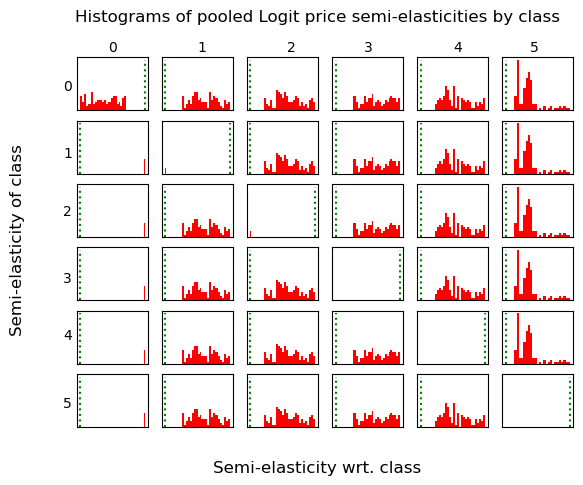

In [93]:
E0p = {j : (E0.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(E0p[j], num_bins, range = (np.quantile(E0p[j], 0.10), np.quantile(E0p[j], 0.90)), color = 'r', alpha = 1) # Logit is blue
    axes[p].vlines(0, 0, 25, 'g', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of pooled Logit price semi-elasticities by class')
fig.supxlabel('Semi-elasticity wrt. class')
fig.supylabel('Semi-elasticity of class')
if OO:
    fig.text(0.11, 0.82, '0', ha = 'center', va = 'center')
    fig.text(0.11, 0.68, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.56, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.42, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.3, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.18, 0.9, '0', ha = 'center', va = 'center')
    fig.text(0.32, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.46, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.58, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.72, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')
else:
    fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

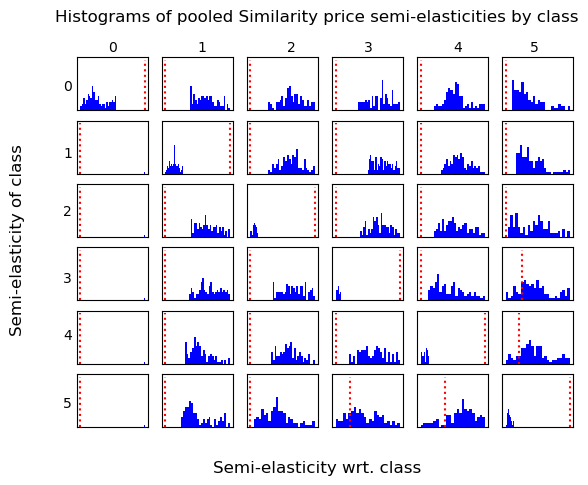

In [94]:
E1p = {j : (E1.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)}

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(E1p[j], num_bins, range = (np.quantile(E1p[j], 0.10), np.quantile(E1p[j], 0.90)), color = 'b', alpha = 1) # Similarity is blue
    axes[p].vlines(0, 0, 25, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of pooled Similarity price semi-elasticities by class')
fig.supxlabel('Semi-elasticity wrt. class')
fig.supylabel('Semi-elasticity of class')

if OO:
    fig.text(0.11, 0.82, '0', ha = 'center', va = 'center')
    fig.text(0.11, 0.68, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.56, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.42, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.3, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.18, 0.9, '0', ha = 'center', va = 'center')
    fig.text(0.32, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.46, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.58, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.72, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')
else:
    fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

#### The mean elasticities for the Logit Model are given as...

In [95]:
pd.DataFrame(E0.mean(axis = 0)).rename_axis(columns = 'Mean elasticity wrt. class', index = 'Mean elasticity of class')

Mean elasticity wrt. class,0,1,2,3,4,5
Mean elasticity of class,,,,,,
0,-0.003261,0.001052,0.000998,0.000711,0.000311,0.000189
1,0.170102,-0.172311,0.000998,0.000711,0.000311,0.000189
2,0.170102,0.001052,-0.172365,0.000711,0.000311,0.000189
3,0.170102,0.001052,0.000998,-0.172652,0.000311,0.000189
4,0.170102,0.001052,0.000998,0.000711,-0.173053,0.000189
5,0.170102,0.001052,0.000998,0.000711,0.000311,-0.173175


#### For Similarity the mean elasticities are...

In [96]:
pd.DataFrame(E1.mean(axis = 0)).rename_axis(columns = 'Mean elasticity wrt. class', index = 'Mean elasticity of class')

Mean elasticity wrt. class,0,1,2,3,4,5
Mean elasticity of class,,,,,,
0,-0.003291,0.001076,0.000990,0.000710,0.000317,0.000199
1,0.146003,-0.273327,0.058294,0.043596,0.017538,0.007896
2,0.146003,0.063005,-0.255848,0.027030,0.015051,0.004759
3,0.146003,0.067949,0.037333,-0.264566,0.011519,0.001762
4,0.146003,0.063012,0.043911,0.023949,-0.281798,0.004923
5,0.146003,0.047050,0.029886,0.008434,0.006708,-0.238081


### Diversion ratios

We now visualize the implied diversion ratios $\mathcal{D}$. If $\bar D_{c\ell}$ denotes the sum of choice probability weigthed diversion ratios, then we have as above that $\bar D_{c\ell} = \sum_{j}\sum_{k} \mathrm{1}_{\{j\in c\}} \mathrm{1}_{\{k\in \ell\}} q_j q_k \mathcal{D}_{jk}$ i.e. more generally $\bar D = (\psi^{\text{class}} \circ q) \mathcal{D} (\psi^{\text{class}} \circ q).'$

In [97]:
def DiversionRatio_agg(data, Theta, q, x, model, direction_var, market_id = 'market', product_id = 'co', char_number = K-1, mode = 'Similarity', outside_option = True):
    ''' 
    '''

    dq_du_agg = ccp_directionalgrad(data, Theta, q, x, model, direction_var, market_id, product_id, model, outside_option)[1]
    D_agg = {}

    for t in np.arange(T):
        D_agg[t] = -100*np.einsum('cl,c->cl', dq_du_agg[t], 1./np.diag(dq_du_agg[t]))

    return D_agg

In [98]:
D_Similarityagg = DiversionRatio_agg(dat, ThetaOptBLP, qOpt, z_logit, Model, 'cla', char_number = pr_index)
D_Logitagg = DiversionRatio_agg(dat, LogitBLP_beta, logit_ccp(LogitBLP_beta, z_logit), z_logit, Model, 'cla', char_number = pr_index, mode = 'Logit')

In [99]:
D0, D1 = np.empty((T, T_agg, T_agg)), np.empty((T, T_agg, T_agg))
for t in np.arange(T):
    D0[t,:,:] = D_Logitagg[t]
    D1[t,:,:] = D_Similarityagg[t]

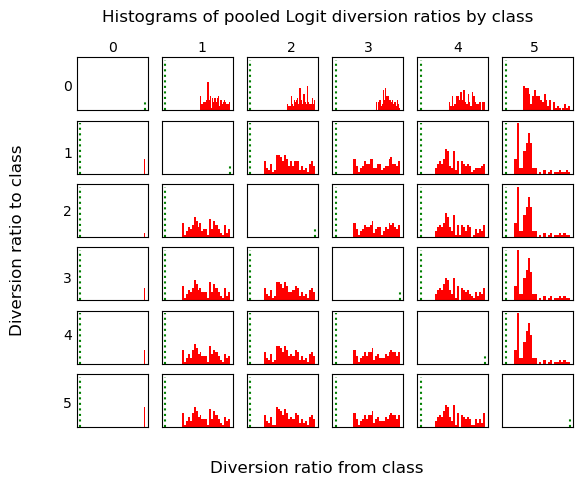

In [100]:
D0p = {j : (D0.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(D0p[j], num_bins, range = (np.quantile(D0p[j], 0.10), np.quantile(D0p[j], 0.90)), color = 'r', alpha = 1) # Logit is red
    axes[p].vlines(0, 0, 25, 'g', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of pooled Logit diversion ratios by class')
fig.supxlabel('Diversion ratio from class')
fig.supylabel('Diversion ratio to class')

if OO:
    fig.text(0.11, 0.82, '0', ha = 'center', va = 'center')
    fig.text(0.11, 0.68, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.56, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.42, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.3, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.18, 0.9, '0', ha = 'center', va = 'center')
    fig.text(0.32, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.46, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.58, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.72, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')
else:
    fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

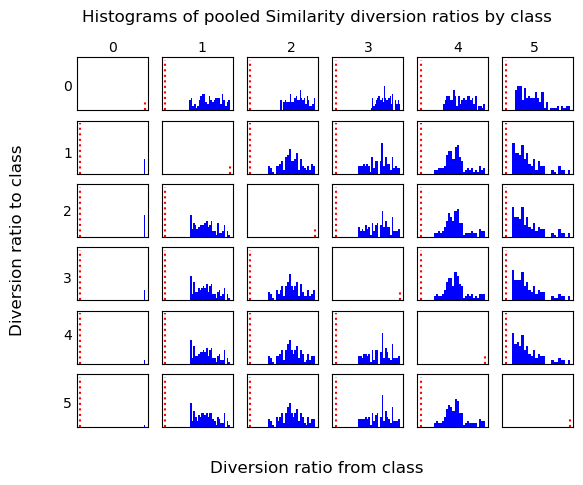

In [101]:
D1p = {j : (D1.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)}

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg, sharex=False, sharey=False)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(D1p[j], num_bins, range = (np.quantile(D1p[j], 0.10), np.quantile(D1p[j], 0.90)), color = 'b', alpha = 1) # Similarity is blue
    axes[p].vlines(0, 0, 25, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of pooled Similarity diversion ratios by class')
fig.supxlabel('Diversion ratio from class')
fig.supylabel('Diversion ratio to class')
if OO:
    fig.text(0.11, 0.82, '0', ha = 'center', va = 'center')
    fig.text(0.11, 0.68, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.56, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.42, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.3, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.18, 0.9, '0', ha = 'center', va = 'center')
    fig.text(0.32, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.46, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.58, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.72, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')
else:
    fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

#### We also calculate the mean diversion ratios within each class. For the Logit Model these are given as...

In [102]:
pd.DataFrame(D0.mean(axis = 0)).rename_axis(columns = 'Mean diversion ratio wrt. class', index = 'Mean diversion ratio of class')

Mean diversion ratio wrt. class,0,1,2,3,4,5
Mean diversion ratio of class,,,,,,
0,-100.000000,32.977441,30.037606,21.805955,9.610813,5.568185
1,98.716873,-100.000000,0.579788,0.413296,0.180329,0.109713
2,98.685594,0.611145,-100.000000,0.413182,0.180340,0.109739
3,98.522081,0.609950,0.578479,-100.000000,0.179993,0.109496
4,98.294337,0.608266,0.576919,0.411271,-100.000000,0.109208
5,98.225371,0.607820,0.576488,0.410944,0.179377,-100.000000


#### For the Similarity Model the mean diversion ratios are...

In [103]:
pd.DataFrame(D1.mean(axis = 0)).rename_axis(columns = 'Mean diversion ratio wrt. class', index = 'Mean diversion ratio of class')

Mean diversion ratio wrt. class,0,1,2,3,4,5
Mean diversion ratio of class,,,,,,
0,-100.000000,33.743095,29.653807,21.433478,9.574822,5.594798
1,98.505070,-100.000000,0.667742,0.479418,0.213535,0.134236
2,98.447235,0.725560,-100.000000,0.479247,0.213606,0.134352
3,98.262319,0.724218,0.666228,-100.000000,0.213190,0.134046
4,98.002884,0.722113,0.664362,0.476963,-100.000000,0.133677
5,97.925531,0.721578,0.663872,0.476580,0.212438,-100.000000


# Conclusion

To conclude we compare parameter estimates from the above models. 

In [104]:
beta_index = pr_index + 1

# arrange lgoit columns
Logit_nest = ['-' for i in np.arange(G)]

Logitbeta_show = [*(np.round(Logit_beta[:beta_index], decimals = 3).astype('str')), *Logit_nest]
Logitse_show = [*(np.round(Logit_SE[:beta_index], decimals=5).astype('str')), *Logit_nest]
Logitp_show = [*Logit_p[:beta_index], *[1 for i in np.arange(G)]]

LogitBLPbeta_show =[*(np.round(LogitBLP_beta[:beta_index], decimals = 3).astype('str')), *Logit_nest]
LogitBLPse_show = [*(np.round(LogitBLP_SE[:beta_index], decimals=5).astype('str')), *Logit_nest]
LogitBLPp_show = [*LogitBLP_p[:beta_index], *[1 for i in np.arange(G)]]

pd.DataFrame({
    'Logit_MLE' : [par + '***' + ' (' + se + ')' if p < 0.01 else par + '**' + ' (' + se + ')' if p < 0.05 else par + '*' + ' (' + se + ')' if p < 0.1 else par + ' (' + se + ')' for p,par,se in zip(Logitp_show, Logitbeta_show, Logitse_show)],
    'Similarity_MLE': [par + '***' + ' (' + se + ')' if p < 0.01 else par + '**' + ' (' + se + ')' if p < 0.05 else par + '*' + ' (' + se + ')' if p < 0.1 else par + ' (' + se + ')' for p,par,se in zip([*Similarity_p[:beta_index], *Similarity_p[K:]], [*(np.round(Similarity_theta[:beta_index], decimals = 3).astype('str')), *(np.round(Similarity_theta[K:], decimals = 3).astype('str'))], [*(np.round(Similarity_SE[:beta_index], decimals=5).astype('str')), *(np.round(Similarity_SE[K:], decimals=5).astype('str'))])],
    'FKN' : [par + '***' + ' (' + se + ')' if p < 0.01 else par + '**' + ' (' + se + ')' if p < 0.05 else par + '*' + ' (' + se + ')' if p < 0.1 else par + ' (' + se + ')' for p,par,se in zip([*FKN_p[:beta_index], *FKN_p[K:]], [*(np.round(FKN_theta[:beta_index], decimals = 3).astype('str')), *(np.round(FKN_theta[K:], decimals = 3).astype('str'))], [*(np.round(FKN_SE[:beta_index], decimals=5).astype('str')), *(np.round(FKN_SE[K:], decimals=5).astype('str'))])],
    'Logit_BLP': [par + '***' + ' (' + se + ')' if p < 0.01 else par + '**' + ' (' + se + ')' if p < 0.05 else par + '*' + ' (' + se + ')' if p < 0.1 else par + ' (' + se + ')' for p,par,se in zip(LogitBLPp_show, LogitBLPbeta_show, LogitBLPse_show)],
    'Similarity_BLP' : [par + '***' + ' (' + se + ')' if p < 0.01 else par + '**' + ' (' + se + ')' if p < 0.05 else par + '*' + ' (' + se + ')' if p < 0.1 else par + ' (' + se + ')' for p,par,se in zip([*OptBLP_p[:beta_index], *OptBLP_p[K:]], [*(np.round(ThetaOptBLP[:beta_index], decimals = 3).astype('str')), *(np.round(ThetaOptBLP[K:], decimals = 3).astype('str'))], [*(np.round(SEOptBLP[:beta_index], decimals=5).astype('str')), *(np.round(SEOptBLP[K:], decimals=5).astype('str'))])]
}, 
index = [*x_vars[:beta_index], *['group_' + par for par in nest_vars]])

,Logit_MLE,Similarity_MLE,FKN,Logit_BLP,Similarity_BLP
in_out,-2.468*** (0.2755),-2.55*** (0.43873),-10.459*** (0.00342),-14.929*** (0.05049),-11.798*** (0.03458)
cy,-0.318** (0.17503),-0.318 (0.22618),-0.501*** (0.0017),-2.359** (0.02596),-0.755*** (0.02002)
hp,-0.457*** (0.18516),-0.457* (0.27293),-3.509*** (0.00255),-6.764*** (0.0296),-5.587*** (0.02601)
we,-0.948*** (0.15371),-0.946*** (0.22234),0.069*** (0.00162),0.03 (0.02894),0.257*** (0.02089)
le,-1.928*** (0.20096),-1.957*** (0.30143),-2.216*** (0.00171),-2.052* (0.03436),-2.405*** (0.02323)
wi,-2.056*** (0.24525),-2.097*** (0.42346),5.496*** (0.00318),10.847*** (0.05173),5.971*** (0.03394)
he,-2.021*** (0.25088),-2.085*** (0.31568),0.342*** (0.00197),-1.041 (0.04148),0.87*** (0.02738)
li,-0.715*** (0.08227),-0.744*** (0.11864),-1.024*** (0.00111),-0.583 (0.01771),-0.77*** (0.01218)
sp,-1.373*** (0.2058),-1.392*** (0.27032),3.283*** (0.00229),5.153*** (0.03692),5.02*** (0.02657)
ac,0.01 (0.08087),-0.055 (0.10572),0.78*** (0.00081),0.518 (0.01579),1.138*** (0.01299)
